In [1]:
## Importe de librerías
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
## Información del jugador
gameName = "Rerzd"
tagLine = "LAN"
region = "americas"
api_key = "RGAPI-14461d83-816b-402e-aa07-0f1121c511bb"  # Sustituye por tu clave de API válida

## Obtener PUUID
request_url = f"https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}?api_key={api_key}"
respuesta = requests.get(request_url)
player_info = respuesta.json()
puuid = player_info.get('puuid')

# Funciones auxiliares
def get_match_data(region, match_id, api_key):
    api_url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
    while True:
        respuesta = requests.get(api_url)
        if respuesta.status_code == 429:
            print("Rate limit exceeded. Sleeping for 10 seconds...")
            time.sleep(10)
            continue
        elif respuesta.status_code != 200:
            print(f"Error fetching match {match_id}: {respuesta.status_code}")
            return None
        else:
            return respuesta.json()

def get_matches(region, puuid, start, count, api_key):
    api_url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={start}&count={count}&api_key={api_key}"
    respuesta = requests.get(api_url)
    if respuesta.status_code != 200:
        print("Error fetching matches: ", respuesta.status_code)
        return []
    return respuesta.json()

def is_valid_match(match_data, puuid):
    try:
        part_index = match_data['metadata']['participants'].index(puuid)
        participant = match_data['info']['participants'][part_index]
        return participant['championName'] == "Rengar" and participant['teamPosition'] == "JUNGLE"
    except:
        return False

# Recopilar partidas filtradas
filtered_matches = {}
start = 0
matches_per_request = 20
required_valid_matches = 50
max_checks = 200

In [3]:
while len(filtered_matches) < required_valid_matches and start < max_checks:
    match_ids = get_matches(region, puuid, start, matches_per_request, api_key)
    if not match_ids:
        break
    for match_id in match_ids:
        if match_id in filtered_matches:
            continue
        print(f"Evaluando partida {match_id}")
        match_data = get_match_data(region, match_id, api_key)
        if not match_data:
            continue
        if is_valid_match(match_data, puuid):
            part_index = match_data['metadata']['participants'].index(puuid)
            p = match_data['info']['participants'][part_index]
            filtered_matches[match_id] = {
                'win': p['win'],
                'championName': p['championName'],
                'role': p['teamPosition'],
                'kills': p['kills'],
                'deaths': p['deaths'],
                'assists': p['assists'],
                'gameDuration': match_data['info'].get('gameDuration'),
                'totalMinionsKilled': p.get('totalMinionsKilled'),
                'totalDamageDealtToChampions': p.get('totalDamageDealtToChampions'),
                'wardsPlaced': p.get('wardsPlaced'),
                'wardsDestroyed': p.get('wardsDestroyed'),
                'dragonKills': p.get('dragonKills'),
                'baronKills': p.get('baronKills'),
                'turretTakedowns': p.get('turretTakedowns'),
                'firstBloodKill': p.get('firstBloodKill'),
                'firstTowerKill': p.get('firstTowerKill'),
                'firstBaron': p.get('firstBaron'),
                'firstDragon': p.get('firstDragon'),
            }
        if len(filtered_matches) >= required_valid_matches:
            break
        time.sleep(2.5)
    start += matches_per_request
    time.sleep(1)

# Crear DataFrame y guardar en CSV
df = pd.DataFrame.from_dict(filtered_matches, orient='index')
df.to_csv("rengar_jungla_partidas.csv", index_label="match_id")
print(f"{len(df)} partidas guardadas en rengar_jungla_partidas.csv")

# --- Limpieza y Feature Engineering ---

# Reemplazo de NaNs por 0 en columnas clave (seguro en estadísticas de partidas)
cols_to_fill = ['totalMinionsKilled', 'totalDamageDealtToChampions', 'wardsPlaced',
                'wardsDestroyed', 'dragonKills', 'baronKills', 'turretTakedowns',
                'firstBloodKill', 'firstTowerKill', 'firstBaron', 'firstDragon']
df[cols_to_fill] = df[cols_to_fill].fillna(0)

# Conversión de tipo (por seguridad)
df['gameDuration'] = pd.to_numeric(df['gameDuration'], errors='coerce')
df['kills'] = pd.to_numeric(df['kills'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')
df['assists'] = pd.to_numeric(df['assists'], errors='coerce')

# Feature Engineering
df['kda'] = (df['kills'] + df['assists']) / df['deaths'].replace(0, 1)
df['dpm'] = df['totalDamageDealtToChampions'] / (df['gameDuration'] / 60)
df['cs_per_min'] = df['totalMinionsKilled'] / (df['gameDuration'] / 60)
df['kp'] = (df['kills'] + df['assists']) / (
    df['kills'] + df['assists'] + df['wardsPlaced'] + df['wardsDestroyed'] + 1e-9)

# Asegurar no hay valores inválidos tras ingeniería
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['kda', 'dpm', 'cs_per_min', 'kp'], inplace=True)

Evaluando partida LA1_1612127134
Evaluando partida LA1_1612117175
Evaluando partida LA1_1612105618
Evaluando partida LA1_1609286904
Evaluando partida LA1_1609280572
Evaluando partida LA1_1602634235
Evaluando partida LA1_1600995560
Evaluando partida LA1_1598294323
Evaluando partida LA1_1554728484
Evaluando partida LA1_1554712970
Evaluando partida LA1_1554708544
Evaluando partida LA1_1554687978
Evaluando partida LA1_1553034414
Evaluando partida LA1_1553016163
Evaluando partida LA1_1552990950
Evaluando partida LA1_1534781476
Evaluando partida LA1_1534729048
Evaluando partida LA1_1534624814
Evaluando partida LA1_1534607036
Evaluando partida LA1_1534563171
Evaluando partida LA1_1534540125
Evaluando partida LA1_1534109175
Evaluando partida LA1_1534049033
Evaluando partida LA1_1534001367
Evaluando partida LA1_1533936605
Evaluando partida LA1_1533851533
Evaluando partida LA1_1531885501
Evaluando partida LA1_1529111924
Evaluando partida LA1_1529105594
Evaluando partida LA1_1529095844
Evaluando 

<ipython-input-3-5e1a17a8b9c9>:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols_to_fill] = df[cols_to_fill].fillna(0)


In [4]:
# --- Análisis de Datos ---
numeric_df = df.select_dtypes(include=[np.number])
print("Estadísticas Descriptivas:")
print(numeric_df.describe())

champion_stats = df.groupby('championName').agg({
    'win': ['count','sum'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'gameDuration': 'mean',
    'totalMinionsKilled': 'mean',
    'totalDamageDealtToChampions': 'mean',
    'wardsPlaced': 'mean',
    'wardsDestroyed': 'mean',
    'dragonKills': 'mean',
    'baronKills': 'mean',
    'turretTakedowns': 'mean',
    'firstBloodKill': 'mean',
    'firstTowerKill': 'mean',
    'firstBaron': 'mean',
    'firstDragon': 'mean',
    'kda': 'mean',
    'dpm': 'mean',
    'cs_per_min': 'mean',
    'kp': 'mean',
})

champion_stats.columns = ['matches', 'wins', 'Avg_kills', 'Avg_deaths', 'Avg_assists', 'Avg_gameDuration',
       'Avg_MinionsKilled', 'Avg_DamageDealtToChampions', 'Avg_wardsPlaced',
       'Avg_wardsDestroyed', 'Avg_dragonKills', 'Avg_baronKills','Avg_turretTakedowns',
       'Avg_firstBloodKill', 'Avg_firstTowerKill', 'Avg_firstBaron', 'Avg_firstDragon',
       'Avg_KDA', 'Avg_DPM', 'Avg_CSperMin', 'Avg_KP']
champion_stats['win_rate'] = champion_stats['wins'] / champion_stats['matches'] * 100
champion_stats.fillna(0, inplace=True)
print(champion_stats)

Estadísticas Descriptivas:
           kills     deaths    assists  gameDuration  totalMinionsKilled  \
count  50.000000  50.000000  50.000000      50.00000           50.000000   
mean    7.400000   6.000000   7.560000    1735.82000           27.260000   
std     5.066899   2.755329   4.468301     474.57606           14.440321   
min     0.000000   0.000000   0.000000     424.00000            2.000000   
25%     3.250000   4.000000   3.250000    1537.75000           17.000000   
50%     6.000000   6.000000   7.000000    1772.00000           26.500000   
75%    10.750000   8.000000  10.750000    2020.50000           39.250000   
max    21.000000  13.000000  18.000000    2709.00000           63.000000   

       totalDamageDealtToChampions  wardsPlaced  wardsDestroyed  dragonKills  \
count                     50.00000    50.000000            50.0    50.000000   
mean                   18175.08000     3.400000             0.0     1.720000   
std                    10253.03014     3.416646 

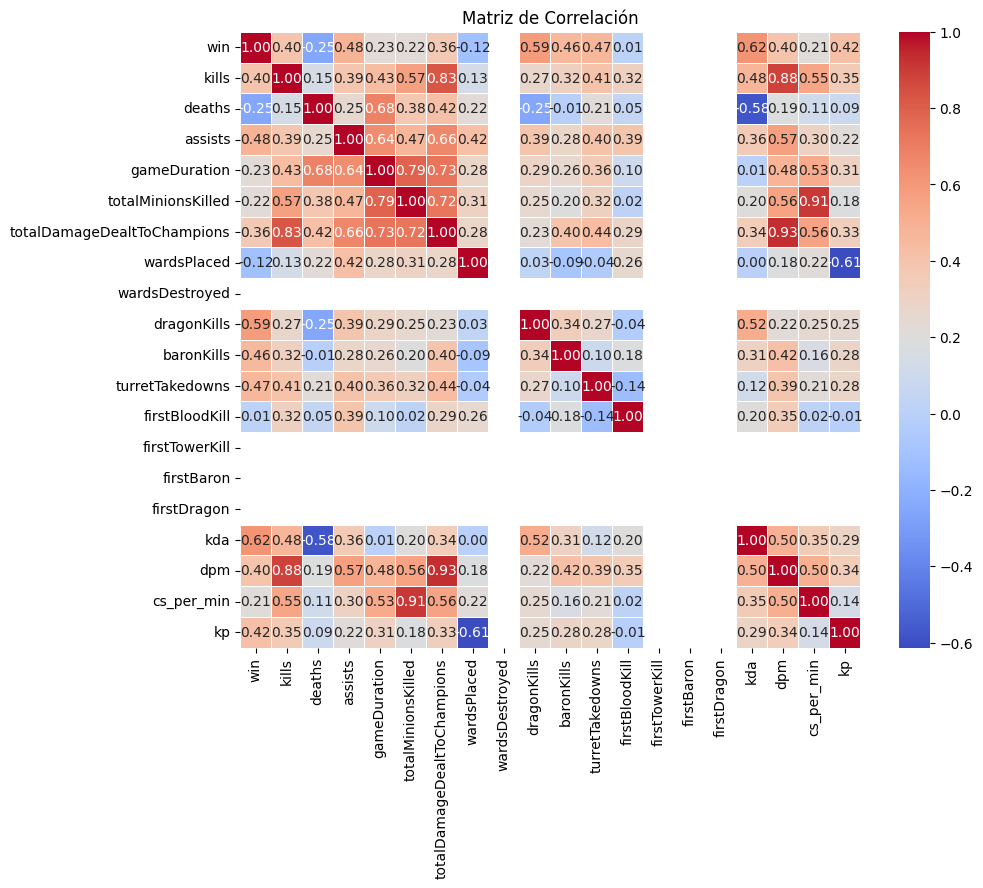

In [5]:
# Matriz de correlación
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

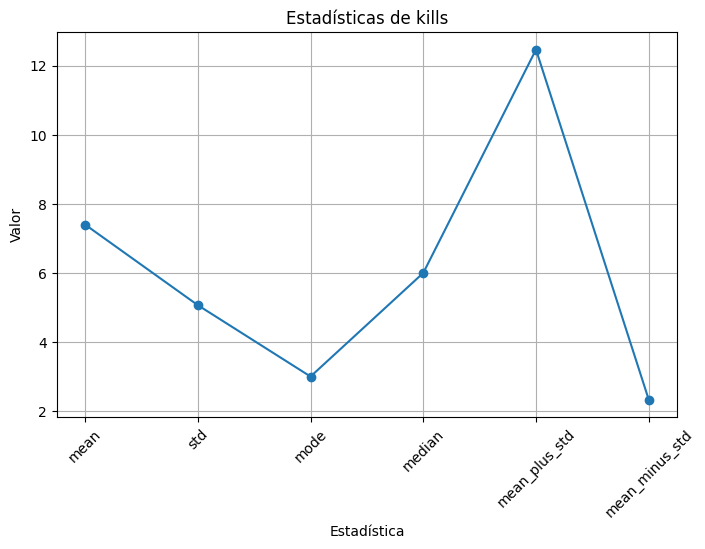

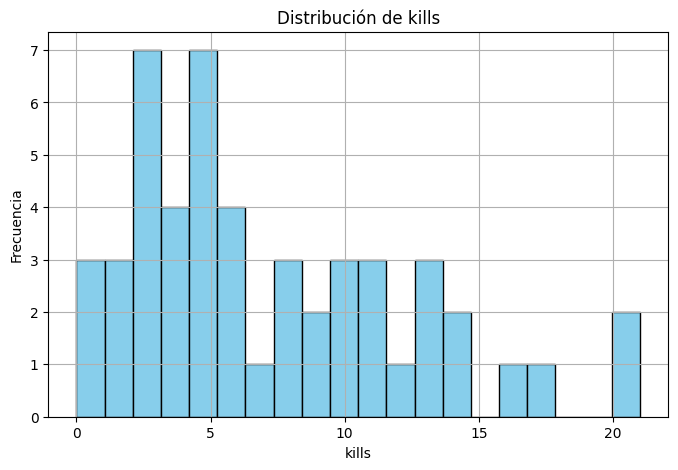

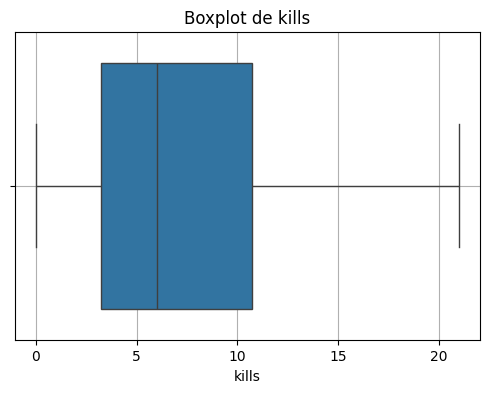

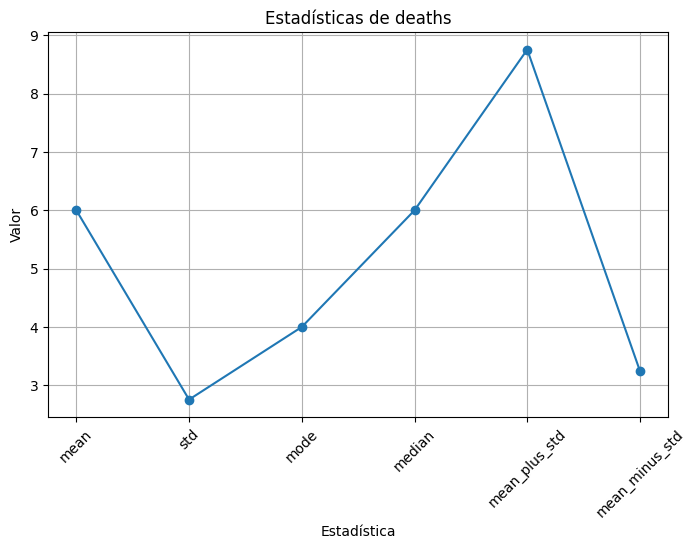

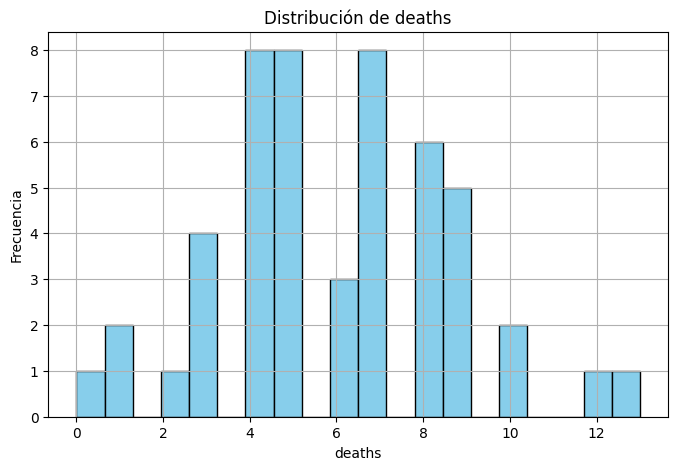

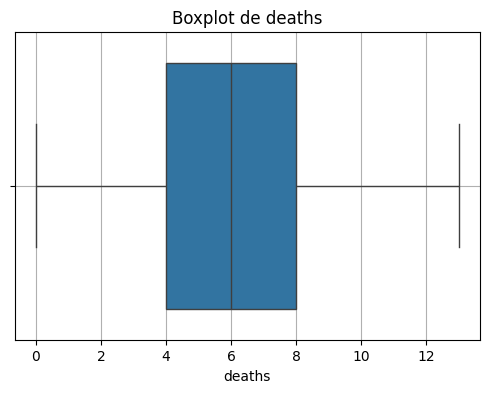

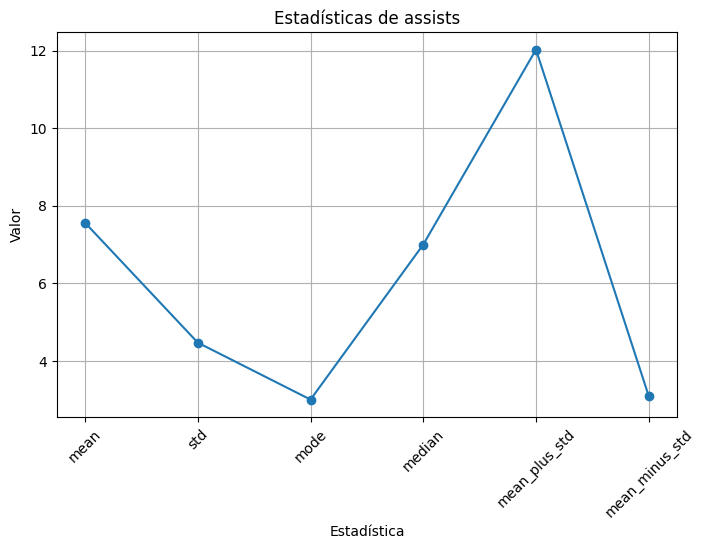

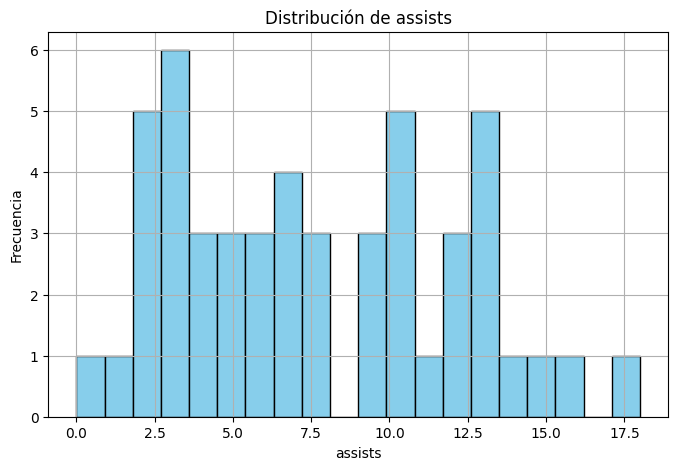

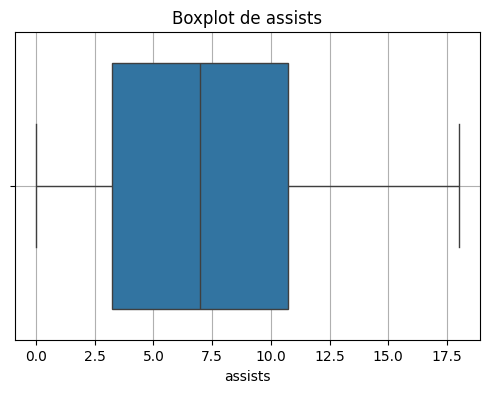

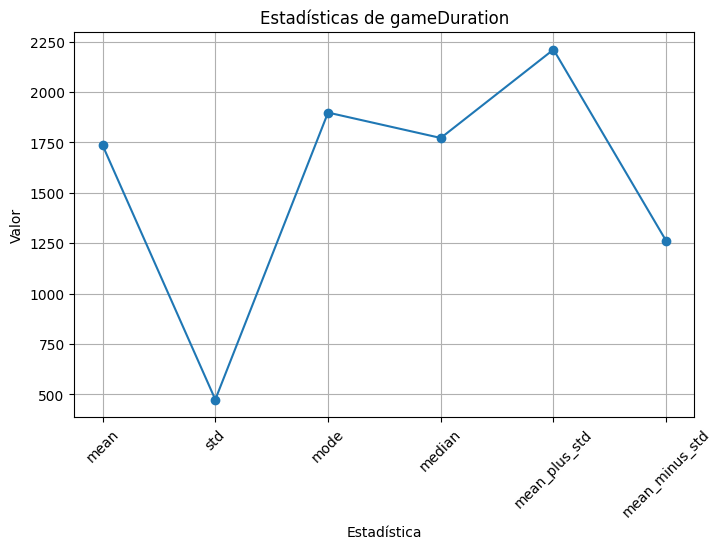

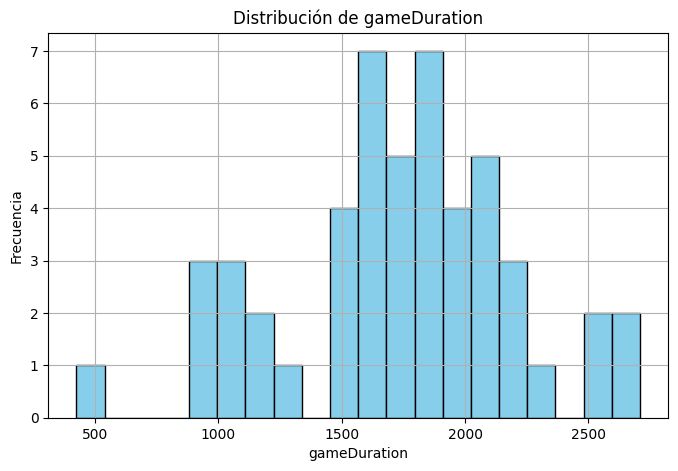

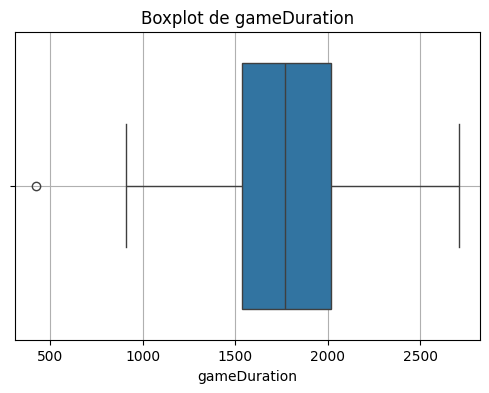

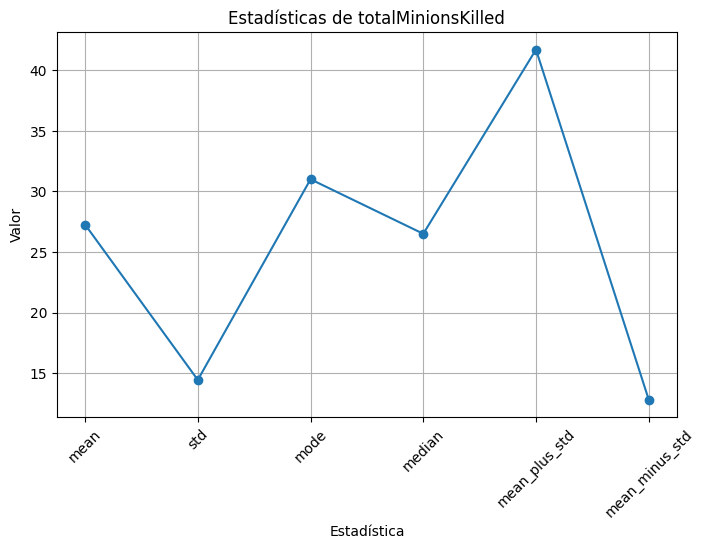

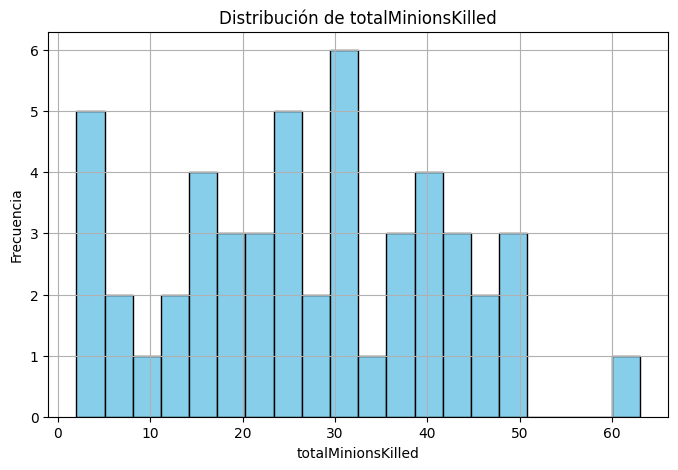

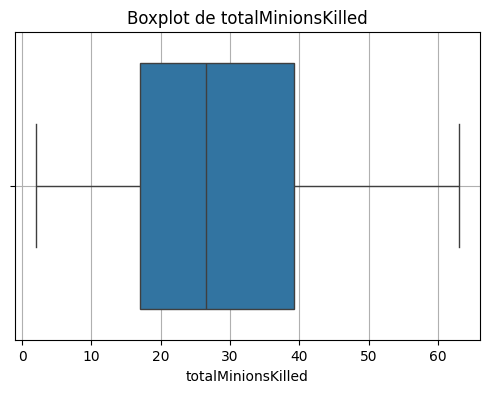

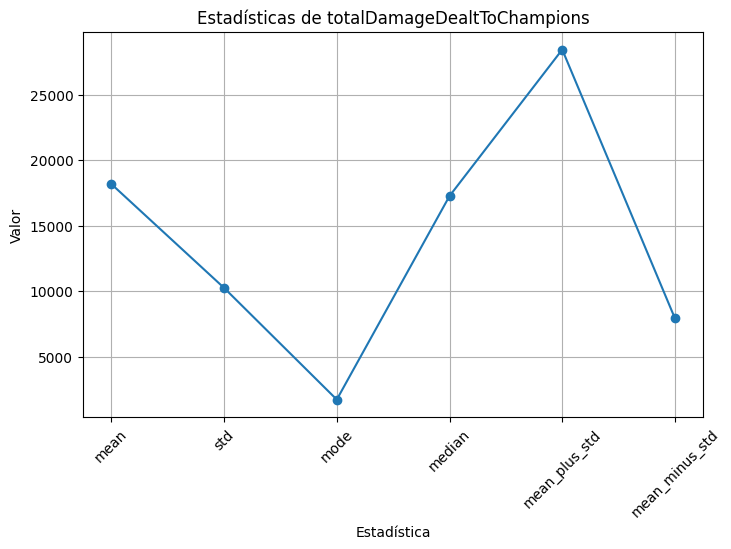

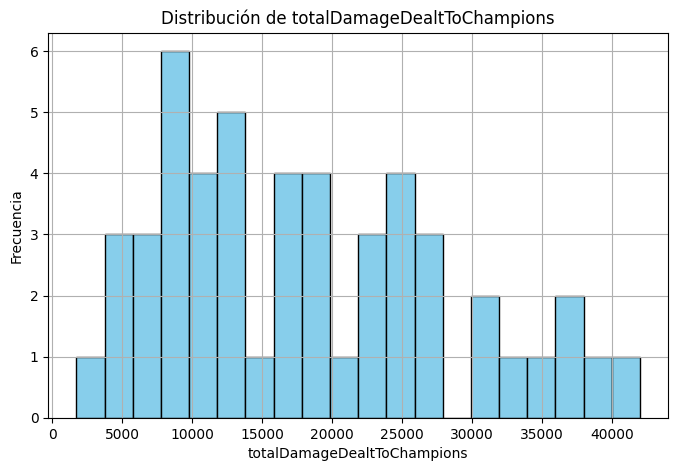

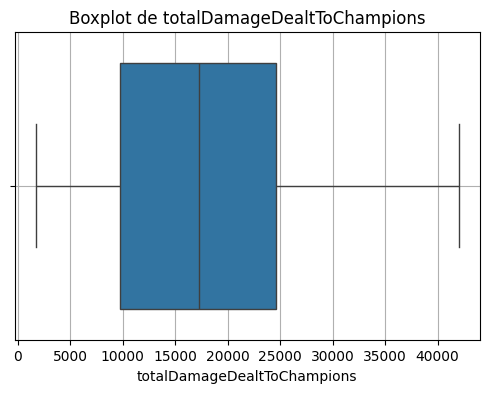

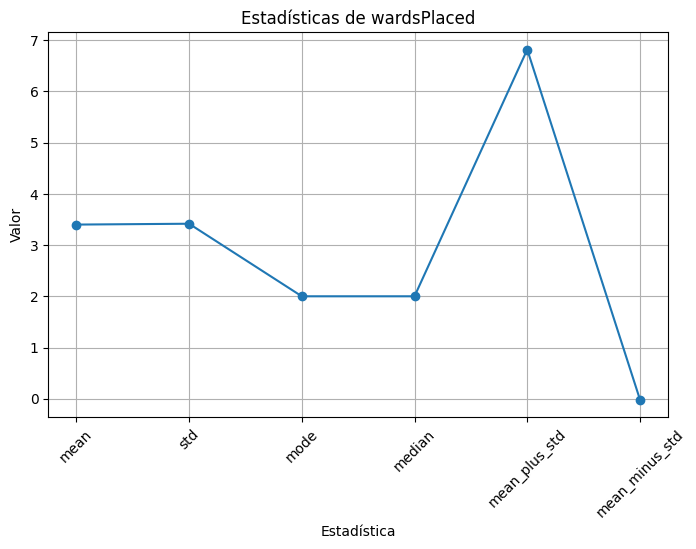

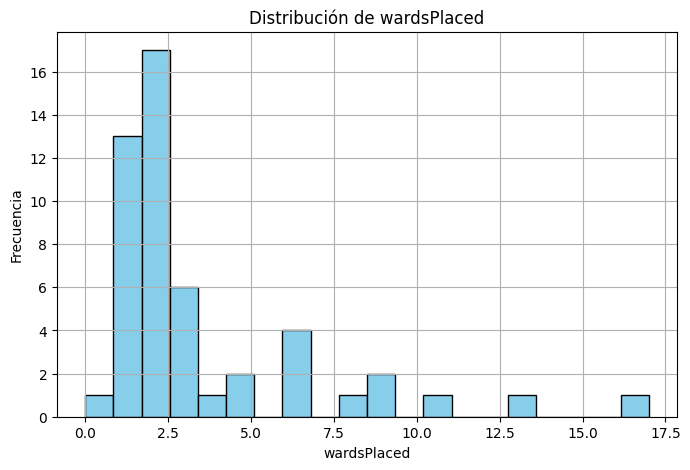

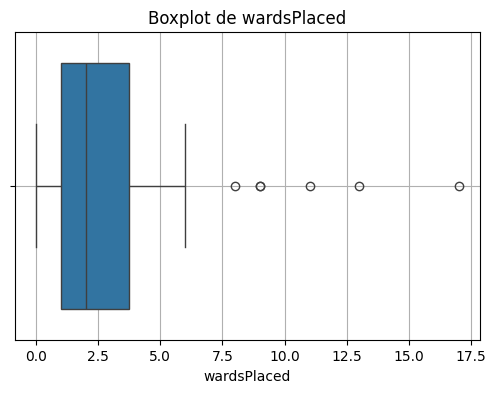

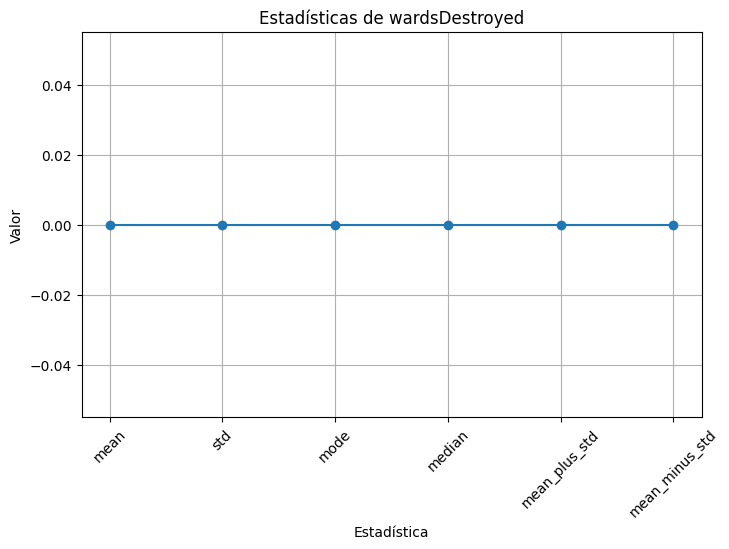

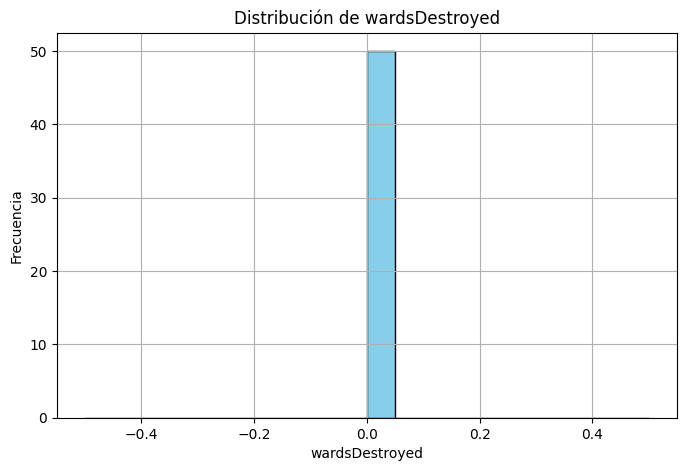

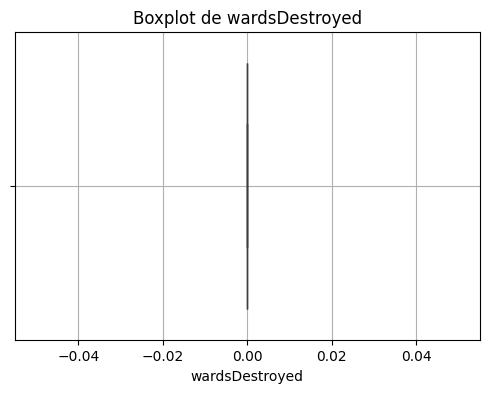

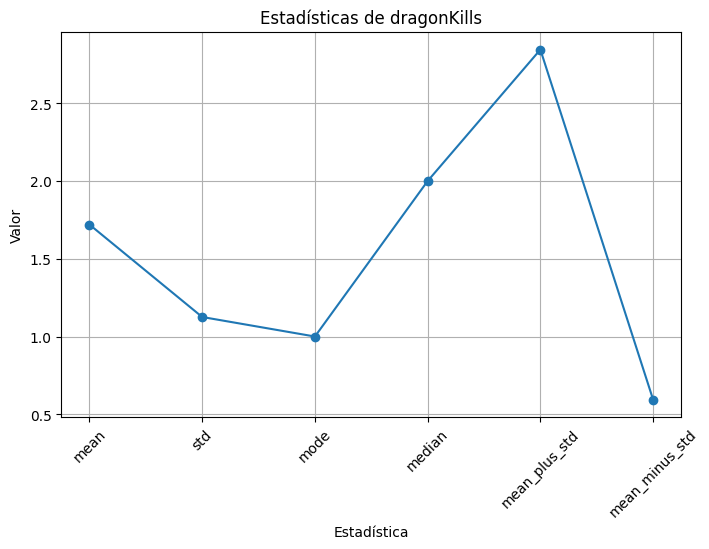

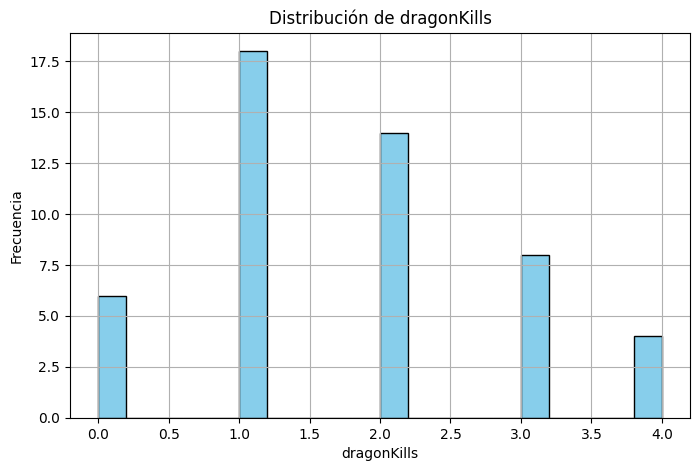

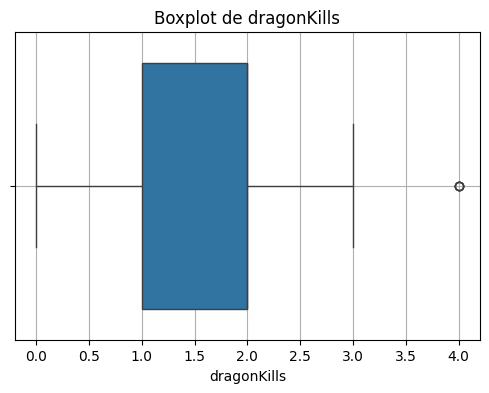

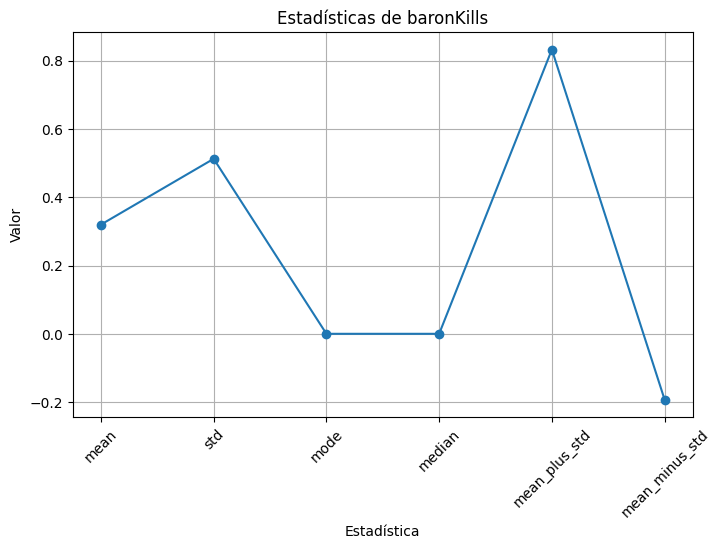

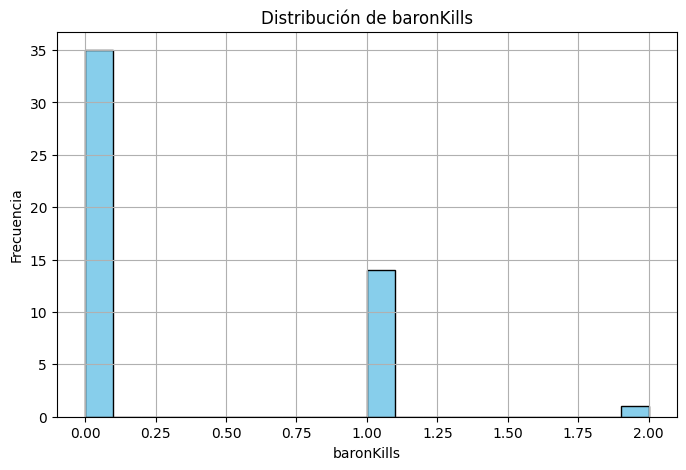

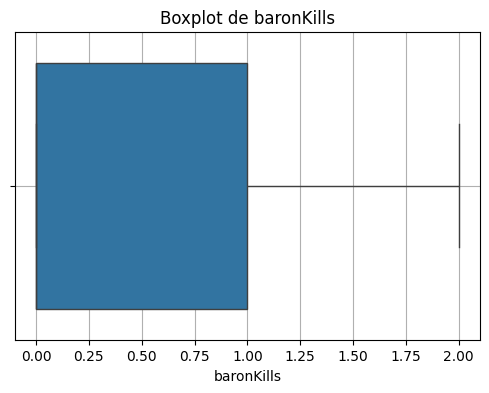

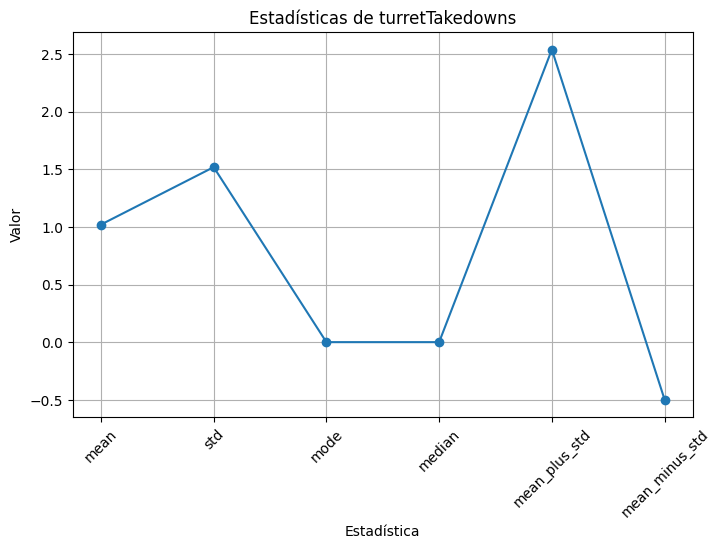

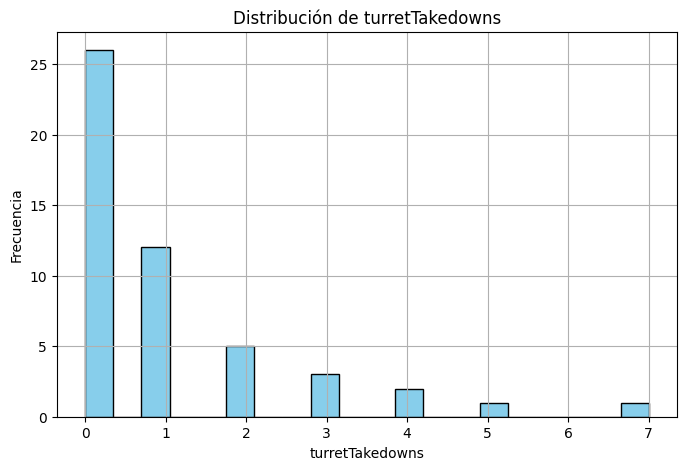

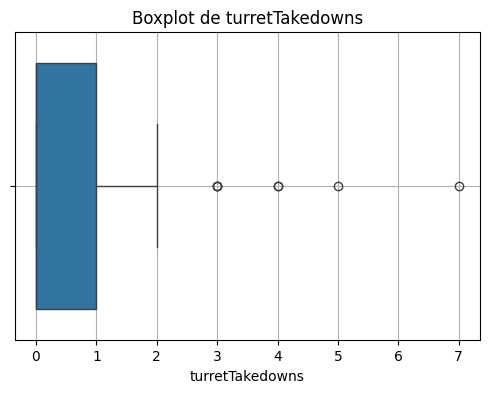

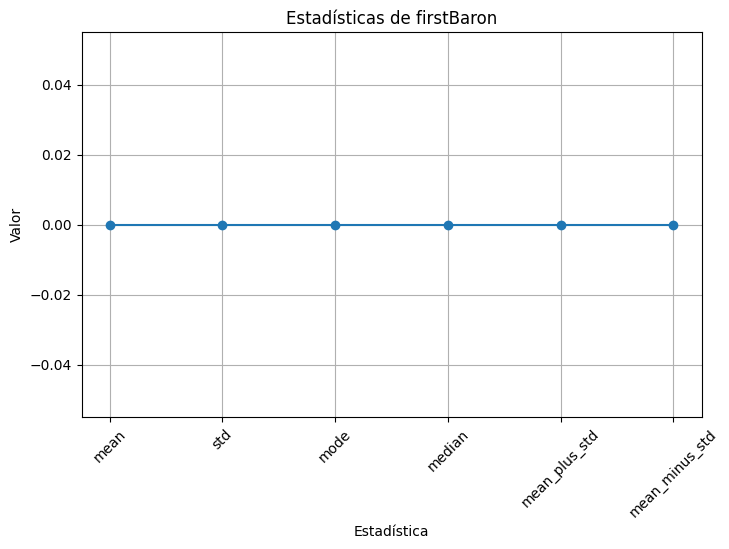

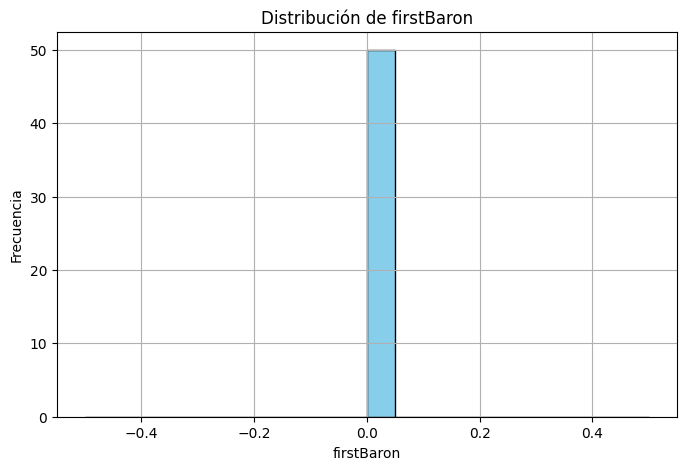

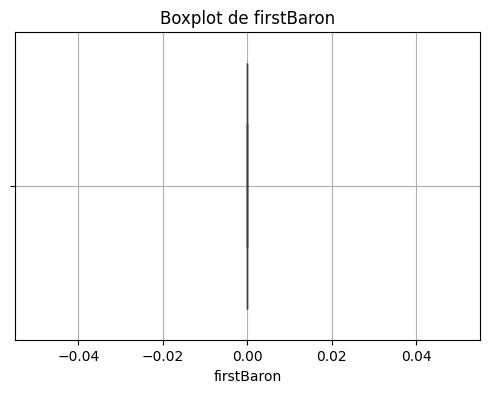

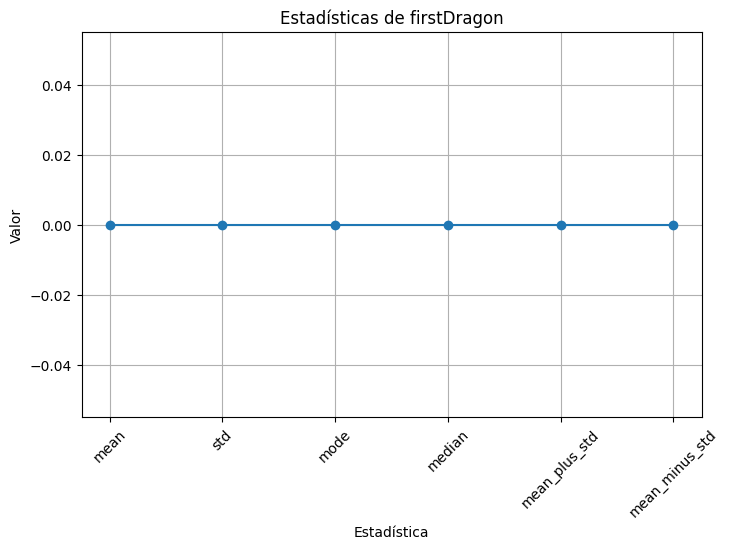

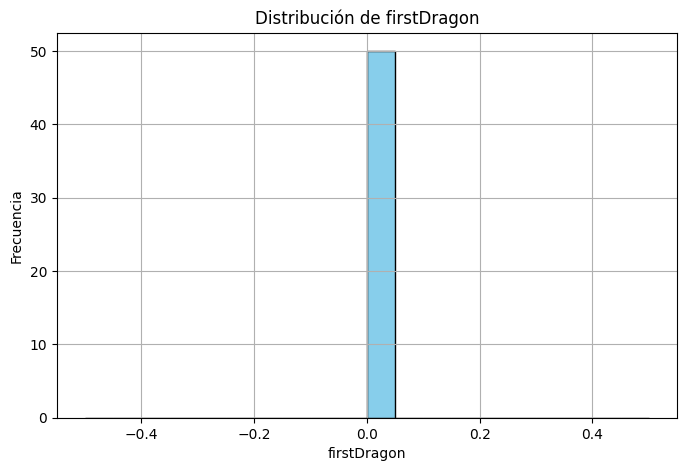

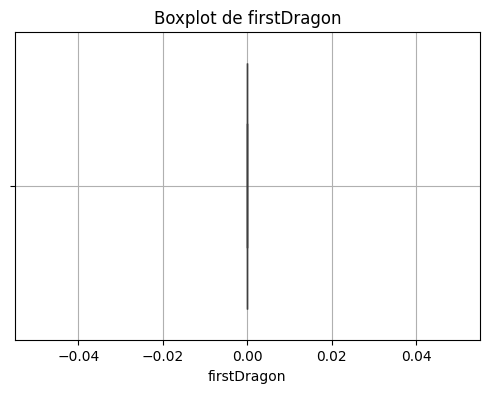

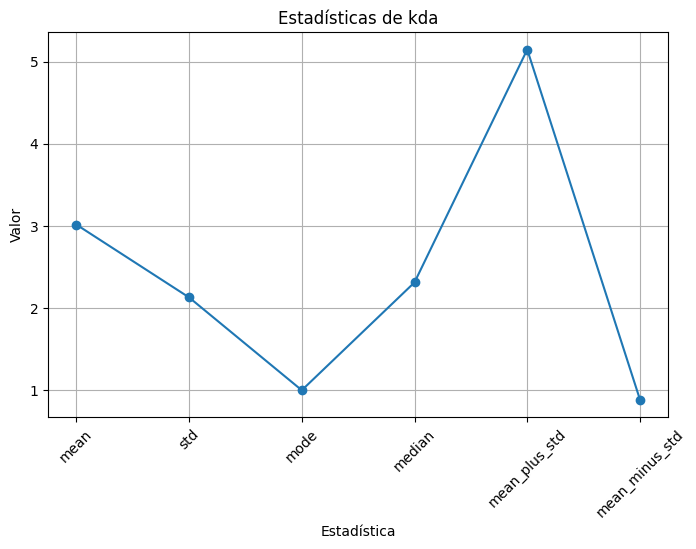

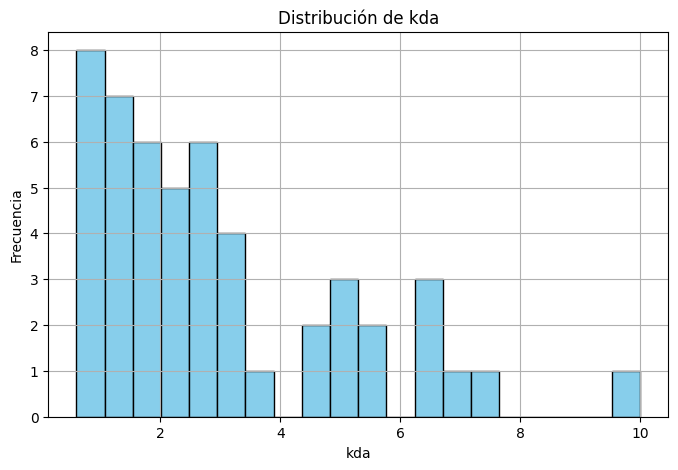

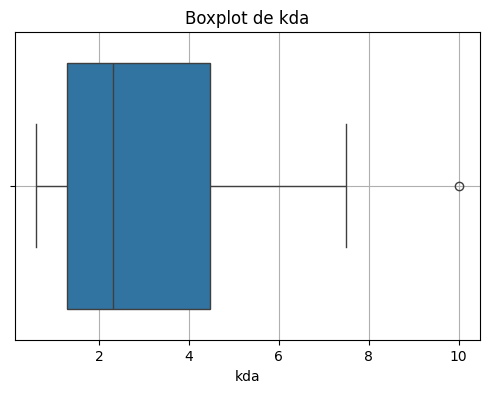

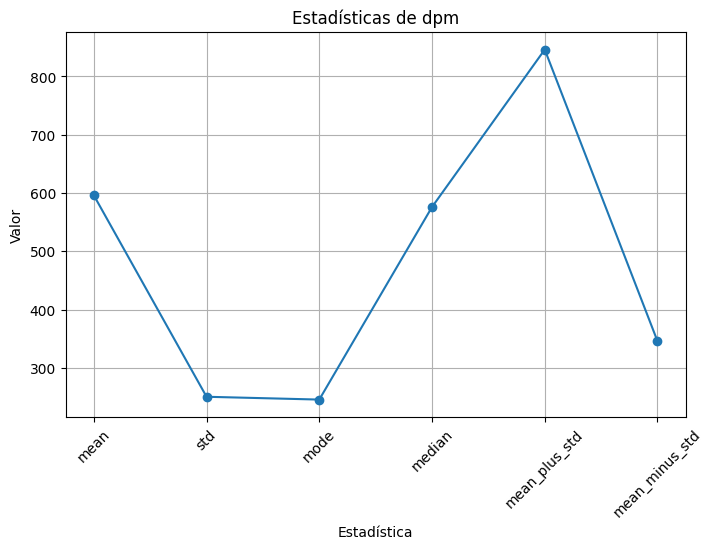

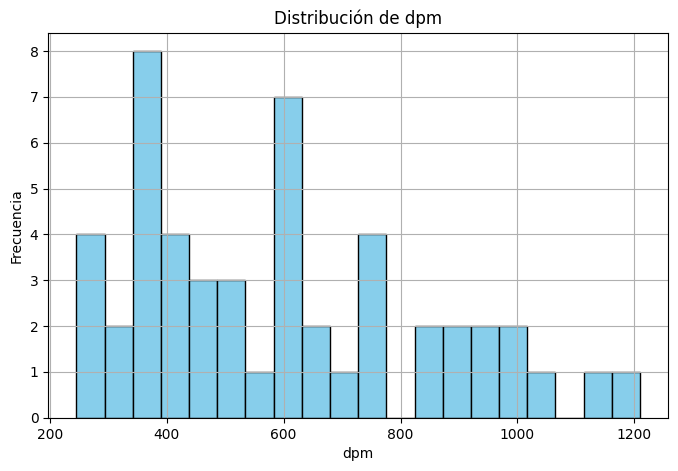

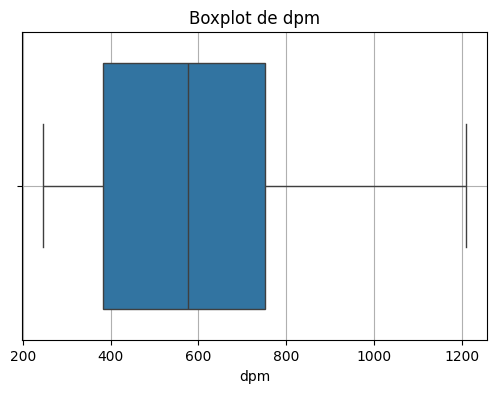

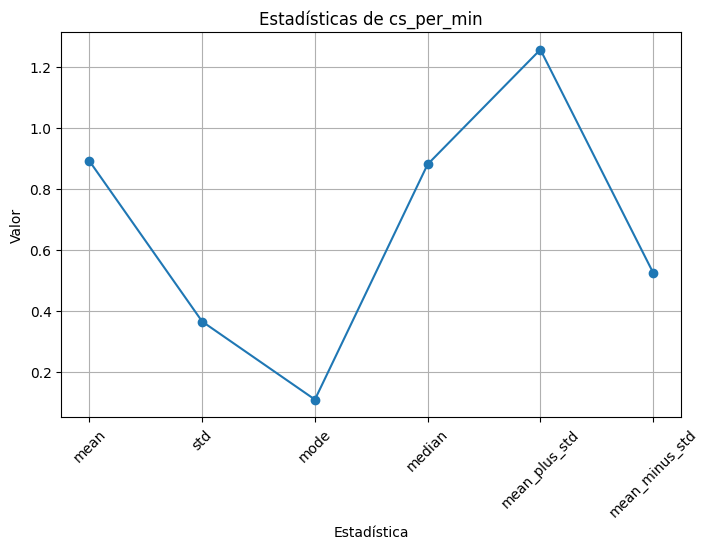

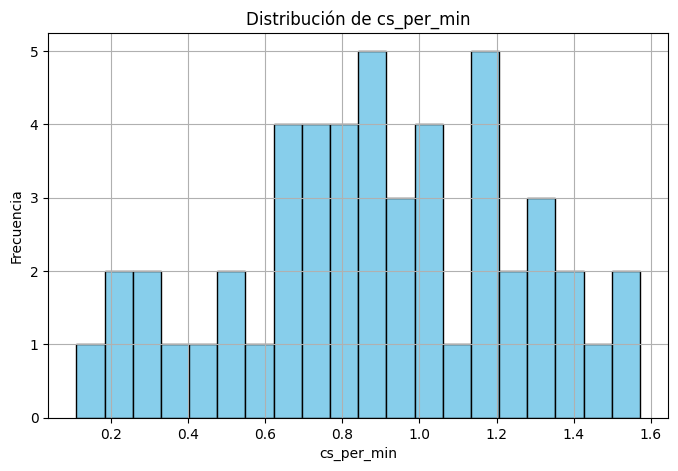

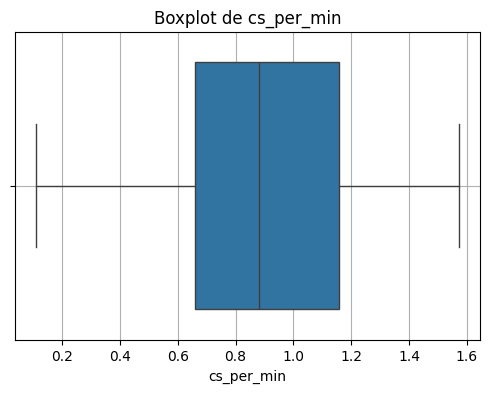

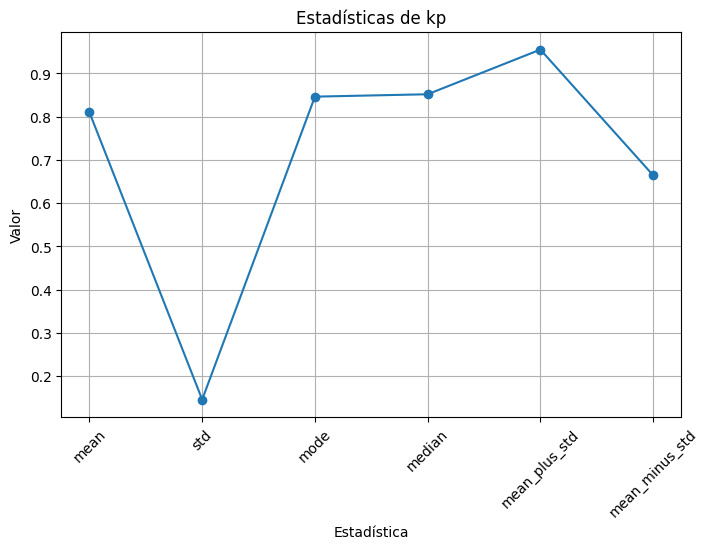

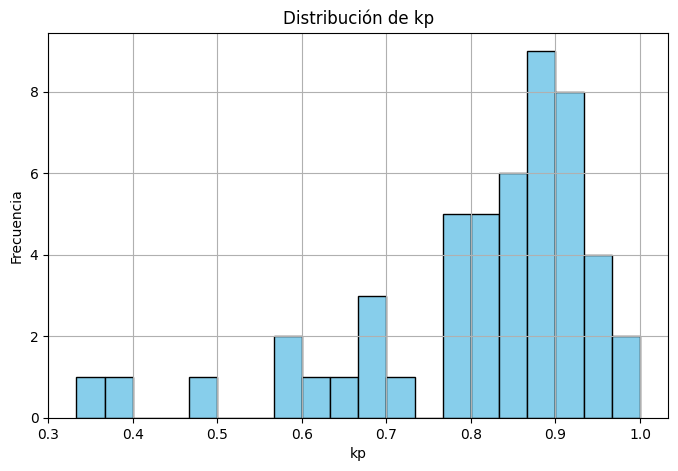

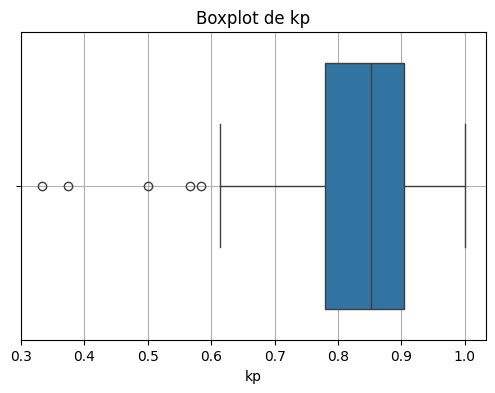

In [6]:
# Estadísticas extendidas
numeric_stats = numeric_df.describe().T
numeric_stats['std'] = numeric_df.std()
numeric_stats['mode'] = numeric_df.mode().iloc[0]
numeric_stats['median'] = numeric_df.median()
numeric_stats['mean_plus_std'] = numeric_stats['mean'] + numeric_stats['std']
numeric_stats['mean_minus_std'] = numeric_stats['mean'] - numeric_stats['std']
stats = ['mean', 'std', 'mode', 'median', 'mean_plus_std', 'mean_minus_std']

# Visualizaciones por columna
for column in numeric_df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(stats, numeric_stats.loc[column, stats], marker='o', linestyle='-')
    plt.title(f'Estadísticas de {column}')
    plt.xlabel('Estadística')
    plt.ylabel('Valor')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(numeric_df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=numeric_df[column])
    plt.title(f'Boxplot de {column}')
    plt.grid(True)
    plt.show()


📊 Estadísticas para: kills


,mean,std,mode,median,mean_plus_std,mean_minus_std
kills,7.40,5.07,3.00,6.00,12.47,2.33


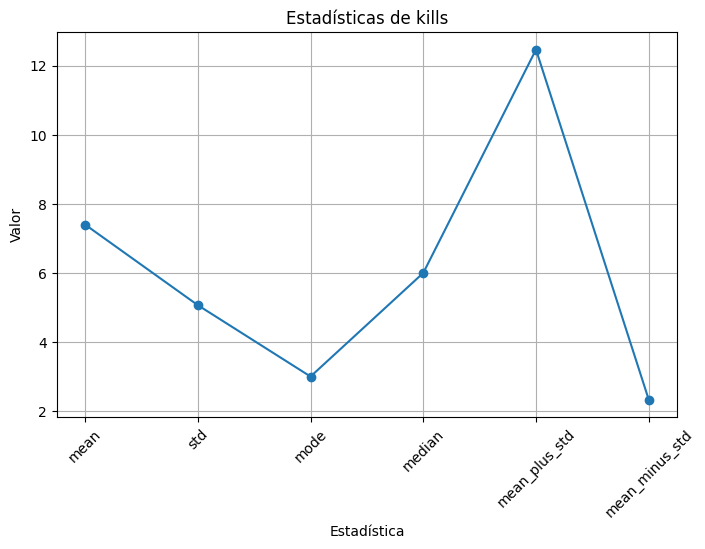

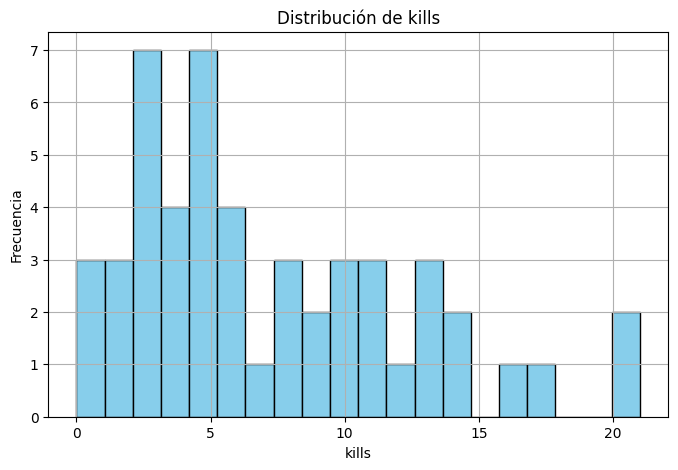

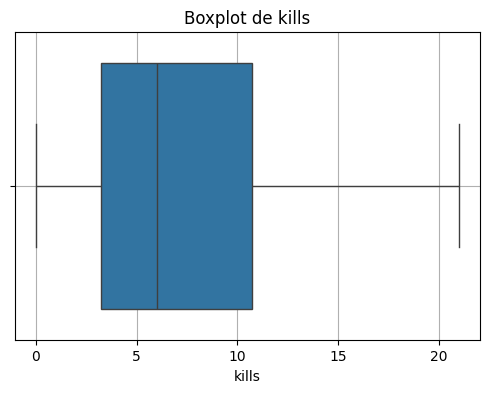


📊 Estadísticas para: deaths


,mean,std,mode,median,mean_plus_std,mean_minus_std
deaths,6.00,2.76,4.00,6.00,8.76,3.24


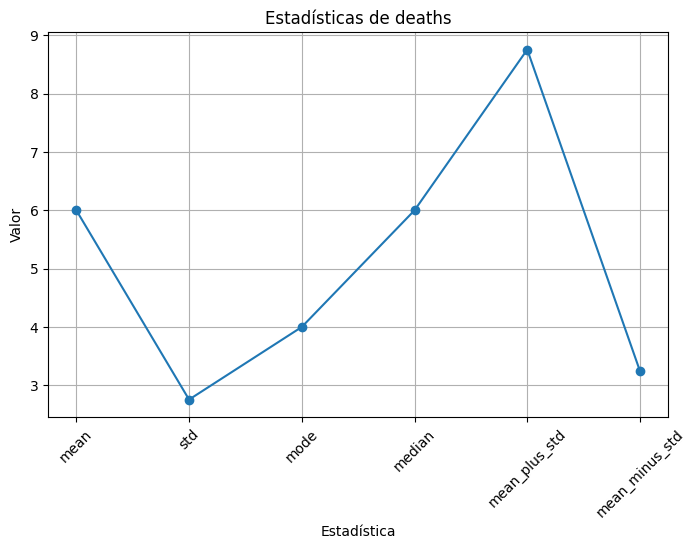

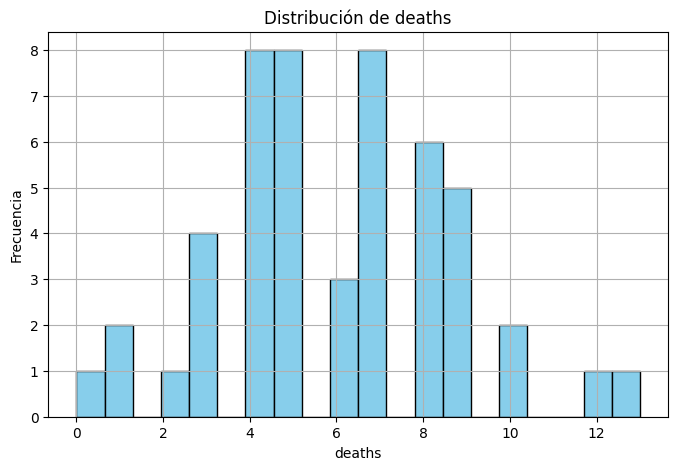

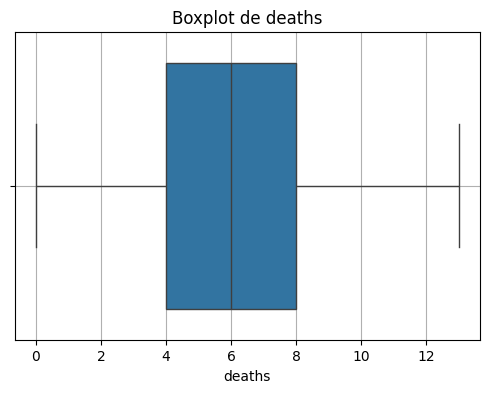


📊 Estadísticas para: assists


,mean,std,mode,median,mean_plus_std,mean_minus_std
assists,7.56,4.47,3.00,7.00,12.03,3.09


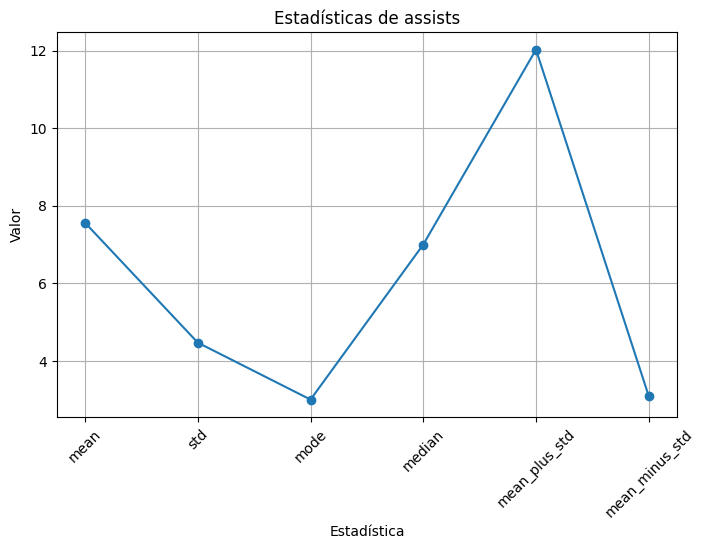

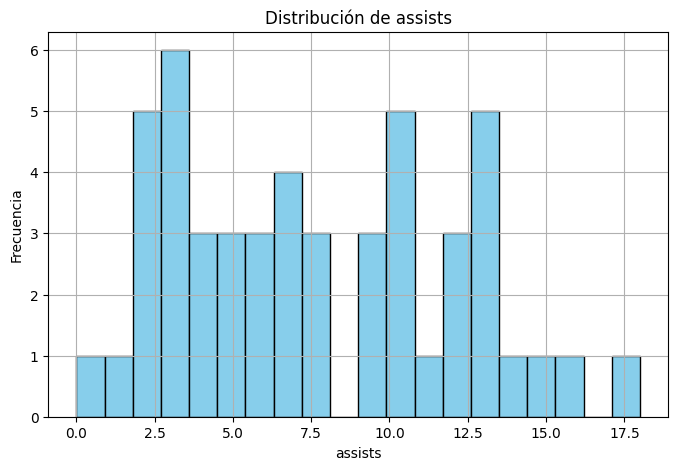

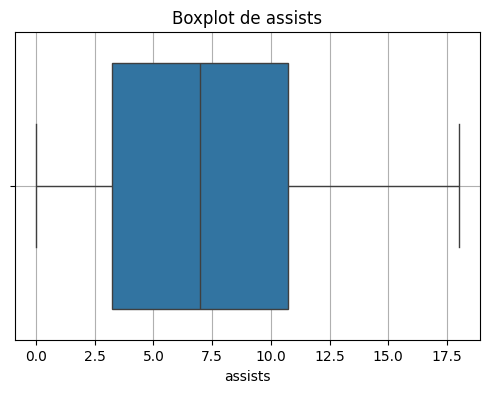


📊 Estadísticas para: gameDuration


,mean,std,mode,median,mean_plus_std,mean_minus_std
gameDuration,1735.82,474.58,1898.00,1772.00,2210.40,1261.24


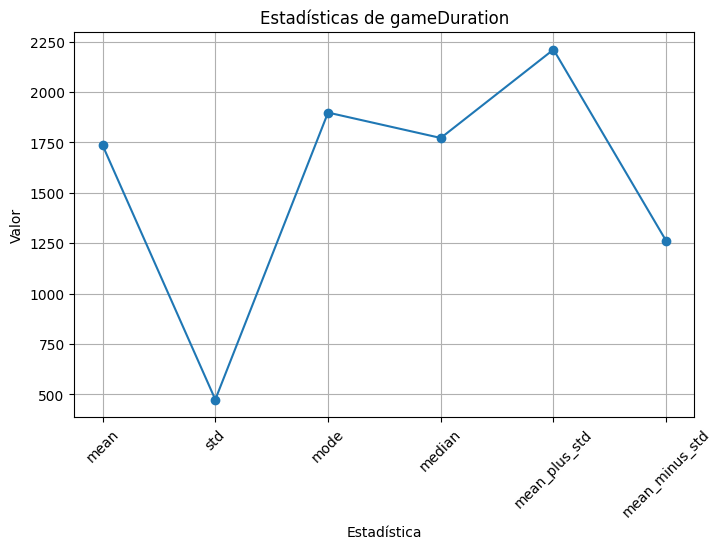

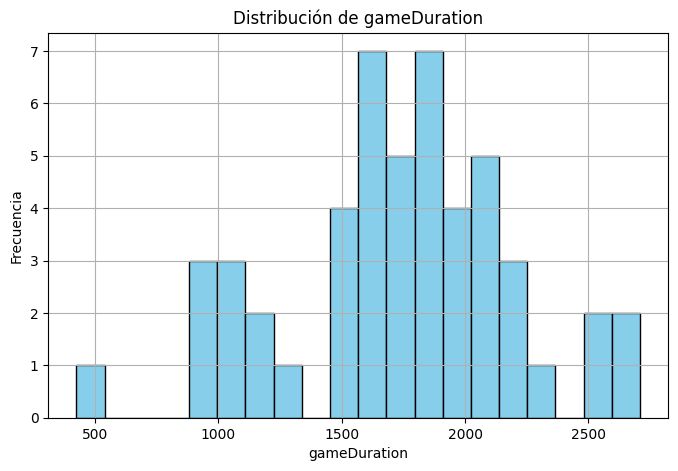

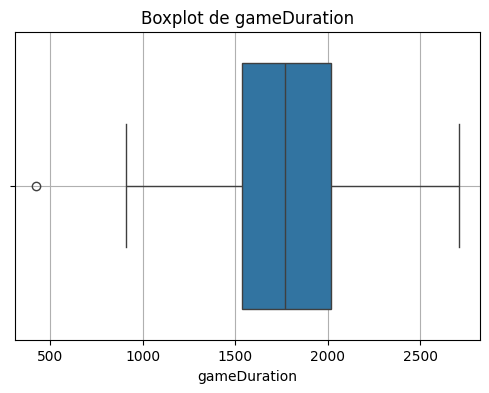


📊 Estadísticas para: totalMinionsKilled


,mean,std,mode,median,mean_plus_std,mean_minus_std
totalMinionsKilled,27.26,14.44,31.00,26.50,41.70,12.82


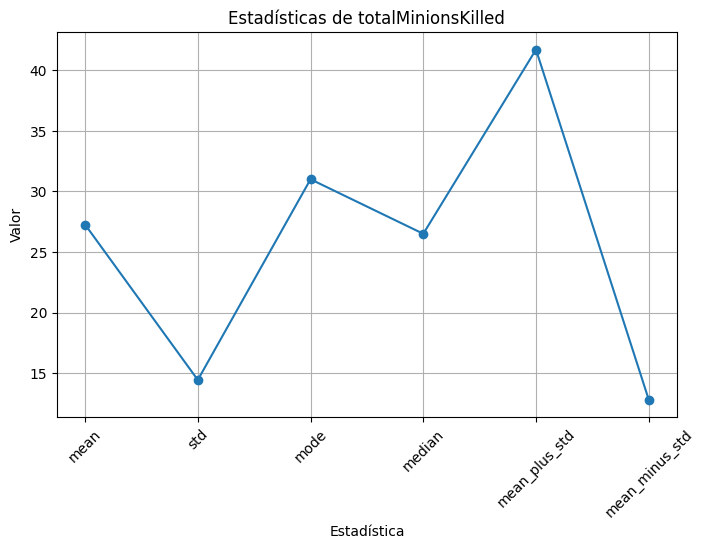

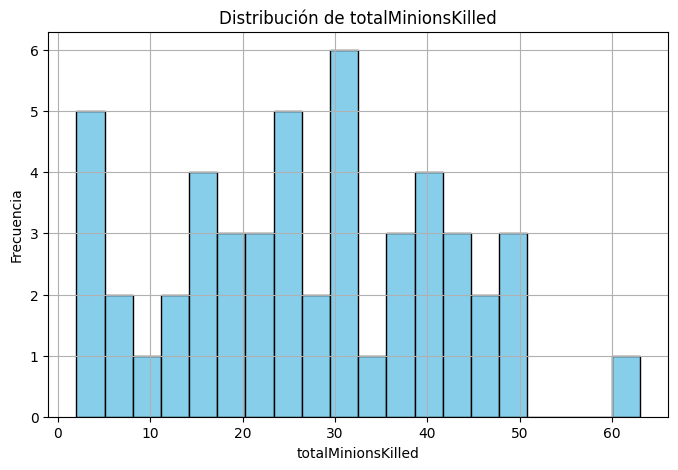

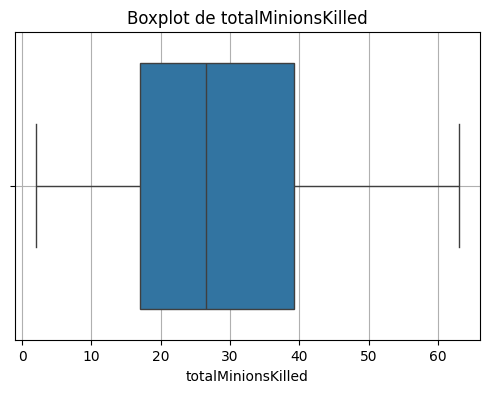


📊 Estadísticas para: totalDamageDealtToChampions


,mean,std,mode,median,mean_plus_std,mean_minus_std
totalDamageDealtToChampions,18175.08,10253.03,1734.00,17259.00,28428.11,7922.05


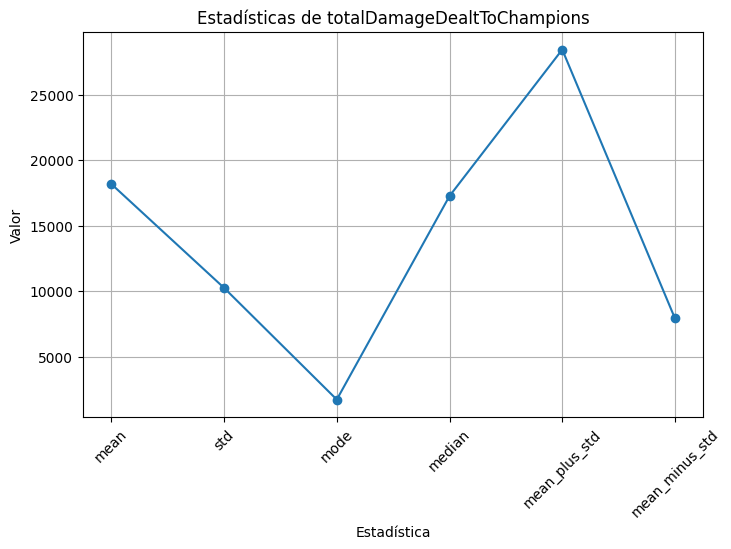

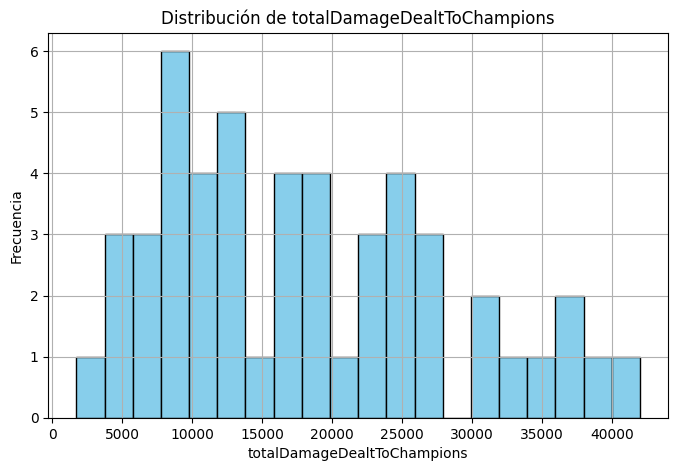

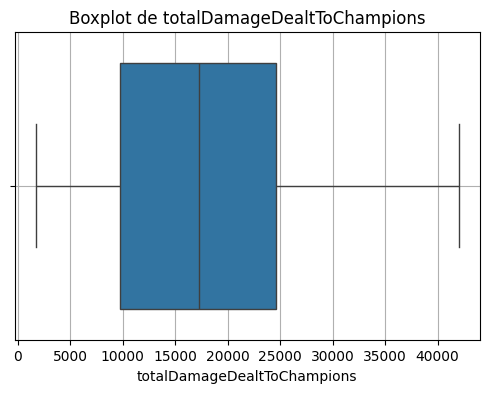


📊 Estadísticas para: wardsPlaced


,mean,std,mode,median,mean_plus_std,mean_minus_std
wardsPlaced,3.40,3.42,2.00,2.00,6.82,-0.02


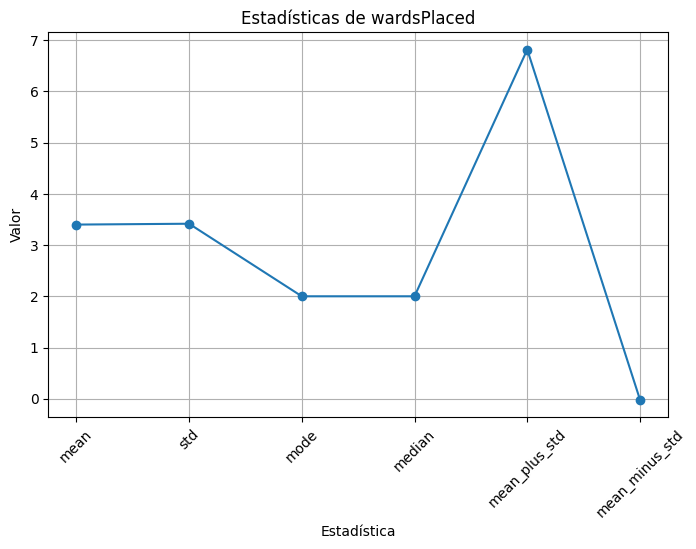

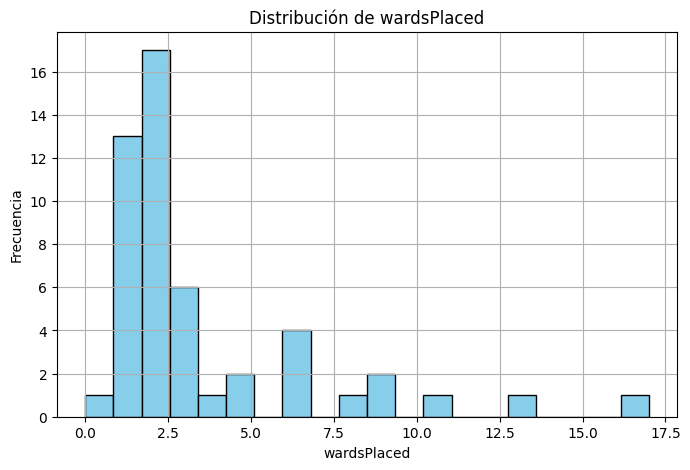

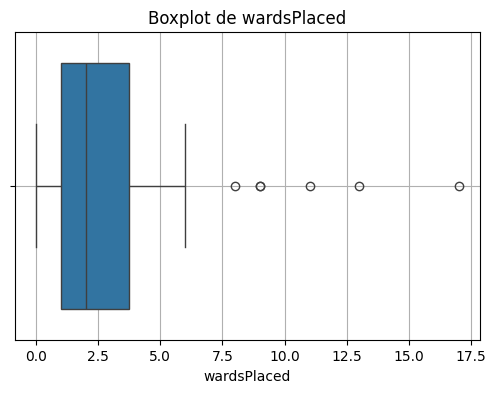


📊 Estadísticas para: wardsDestroyed


,mean,std,mode,median,mean_plus_std,mean_minus_std
wardsDestroyed,0.00,0.00,0.00,0.00,0.00,0.00


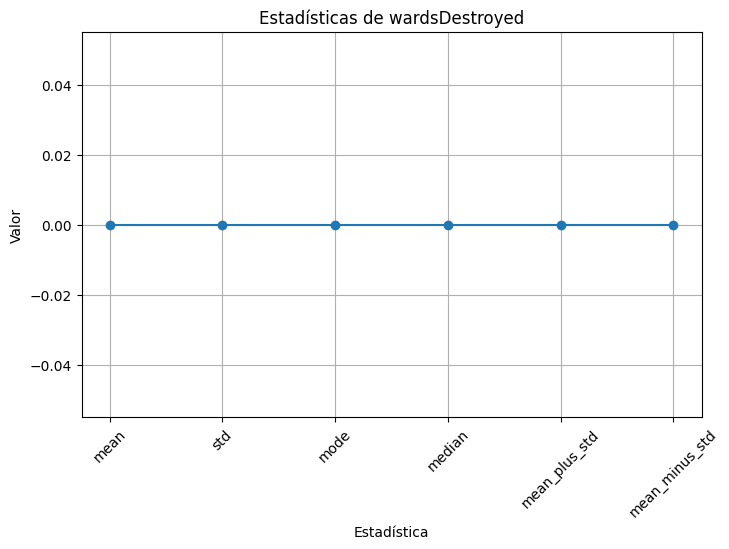

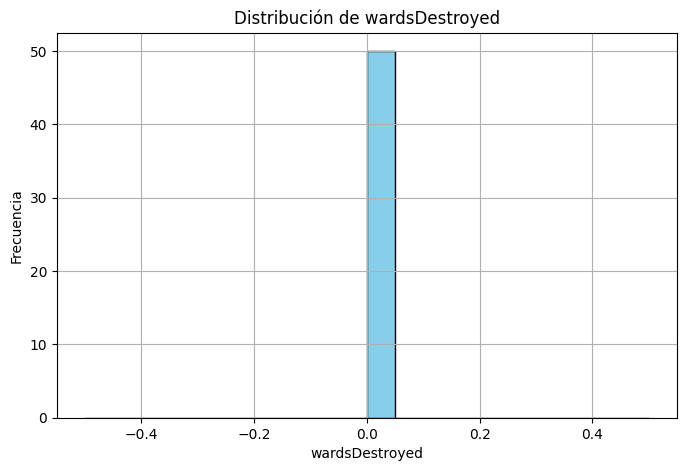

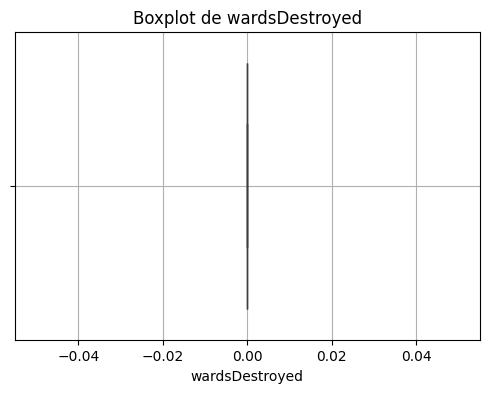


📊 Estadísticas para: dragonKills


,mean,std,mode,median,mean_plus_std,mean_minus_std
dragonKills,1.72,1.13,1.00,2.00,2.85,0.59


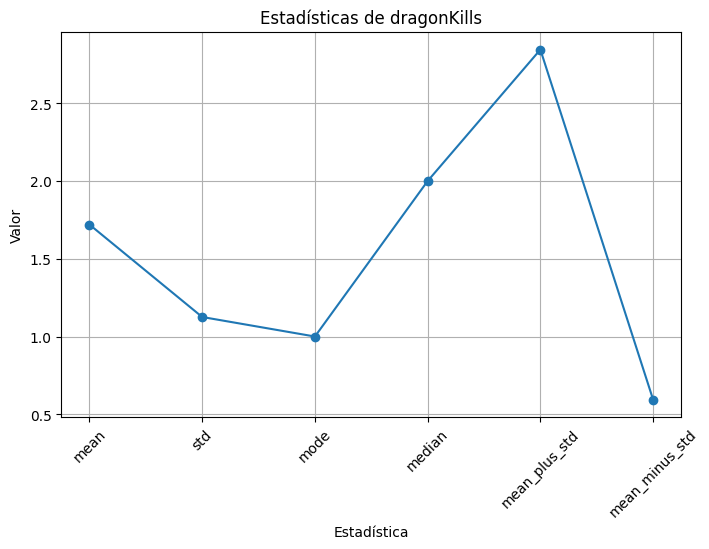

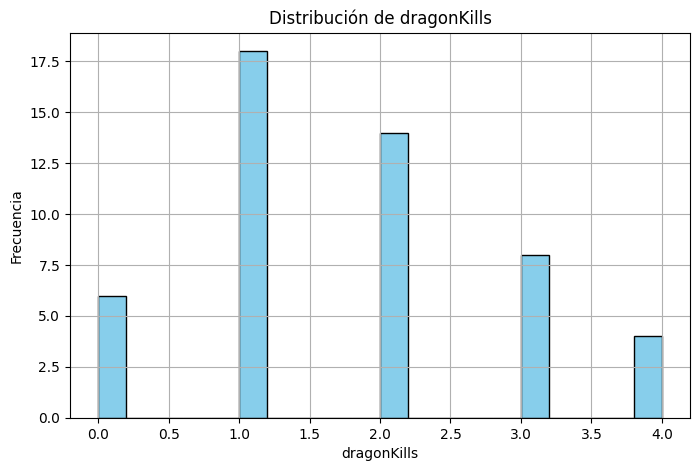

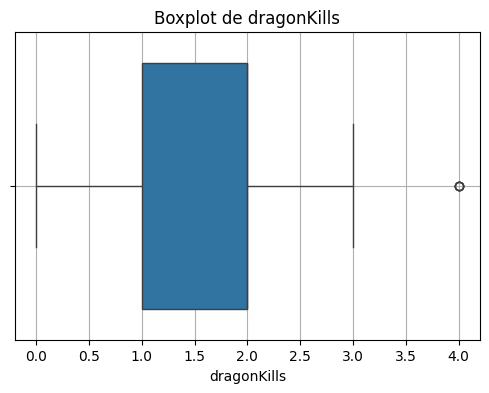


📊 Estadísticas para: baronKills


,mean,std,mode,median,mean_plus_std,mean_minus_std
baronKills,0.32,0.51,0.00,0.00,0.83,-0.19


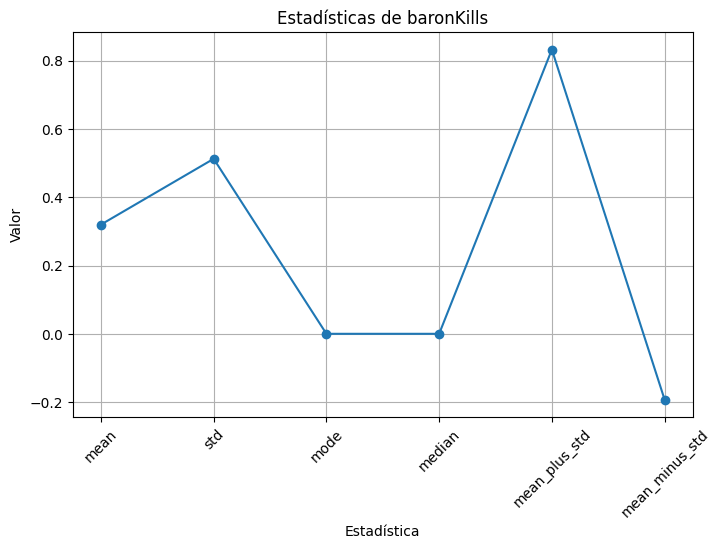

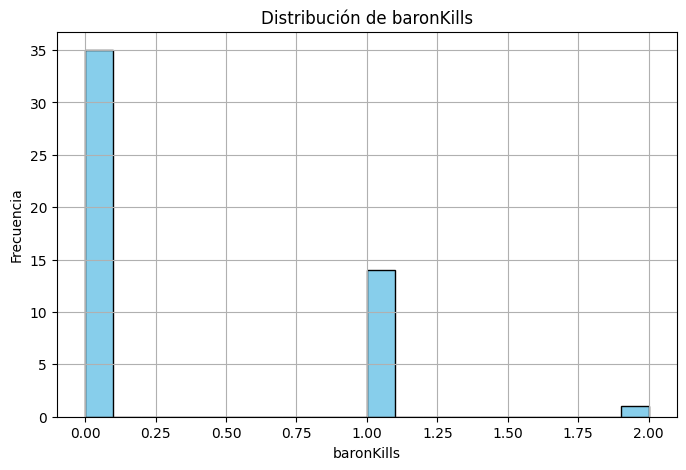

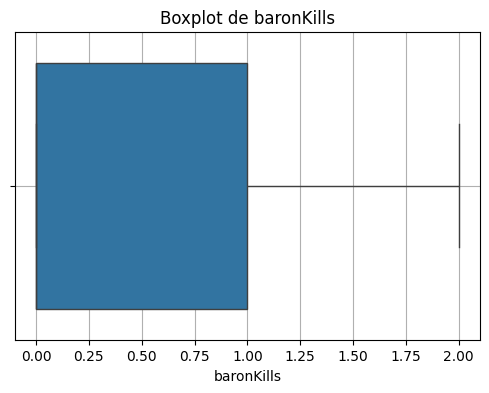


📊 Estadísticas para: turretTakedowns


,mean,std,mode,median,mean_plus_std,mean_minus_std
turretTakedowns,1.02,1.52,0.00,0.00,2.54,-0.50


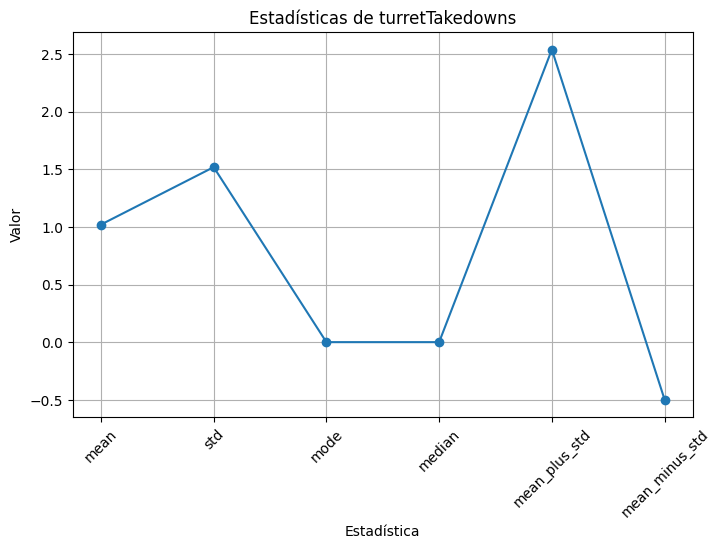

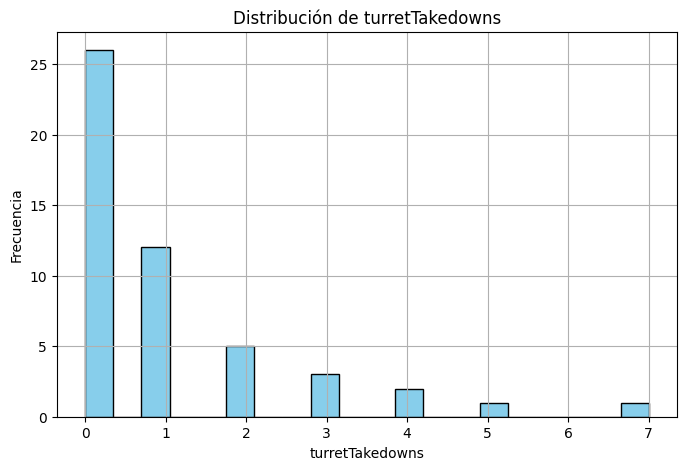

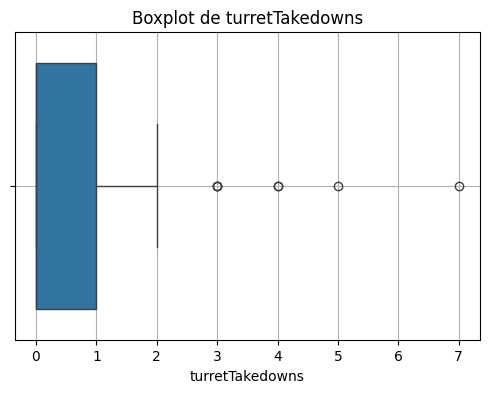


📊 Estadísticas para: firstBaron


,mean,std,mode,median,mean_plus_std,mean_minus_std
firstBaron,0.00,0.00,0.00,0.00,0.00,0.00


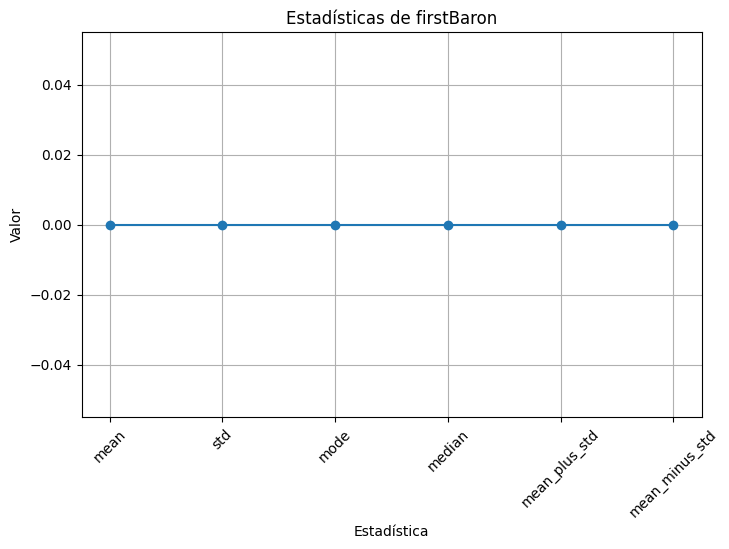

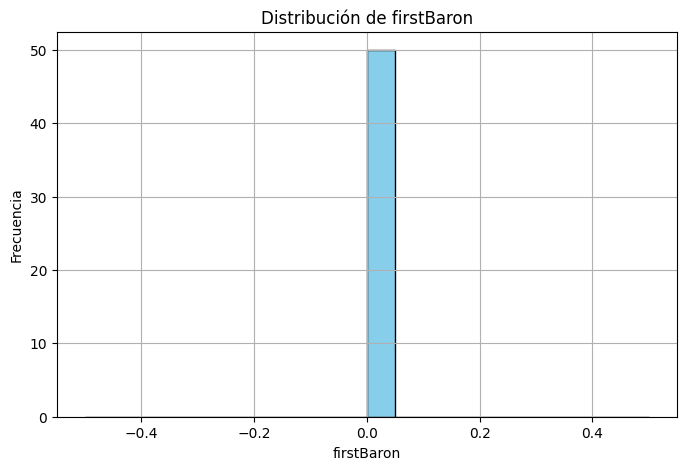

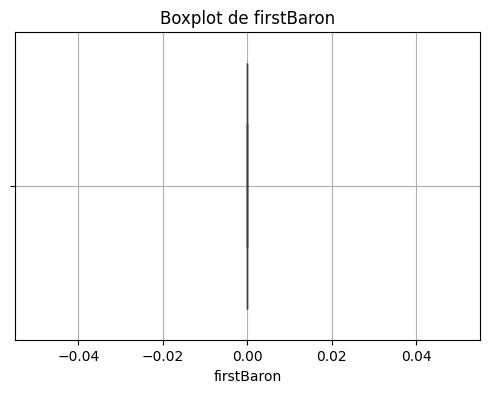


📊 Estadísticas para: firstDragon


,mean,std,mode,median,mean_plus_std,mean_minus_std
firstDragon,0.00,0.00,0.00,0.00,0.00,0.00


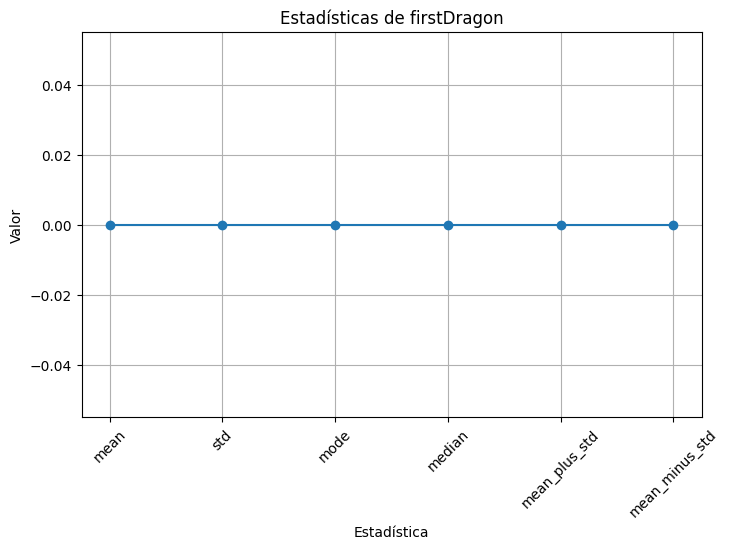

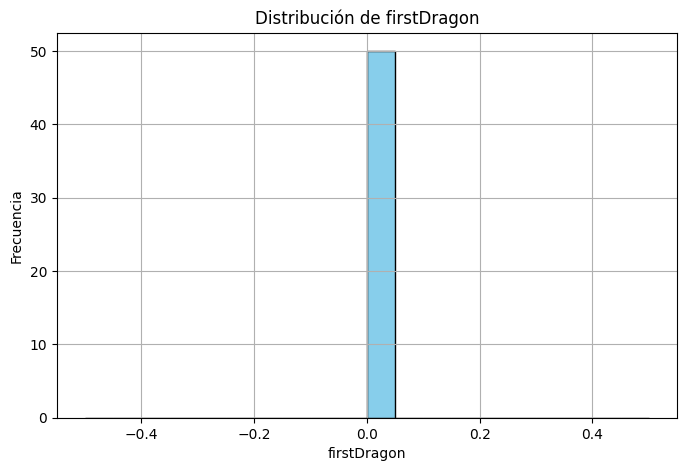

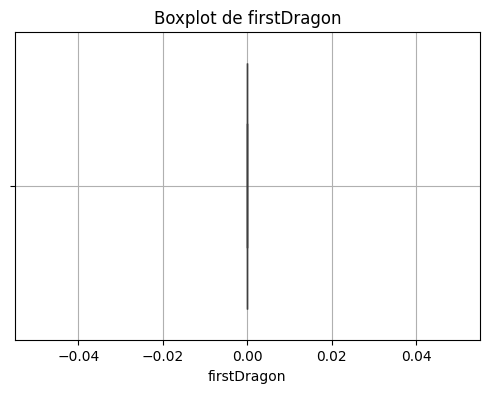


📊 Estadísticas para: kda


,mean,std,mode,median,mean_plus_std,mean_minus_std
kda,3.02,2.13,1.00,2.31,5.15,0.89


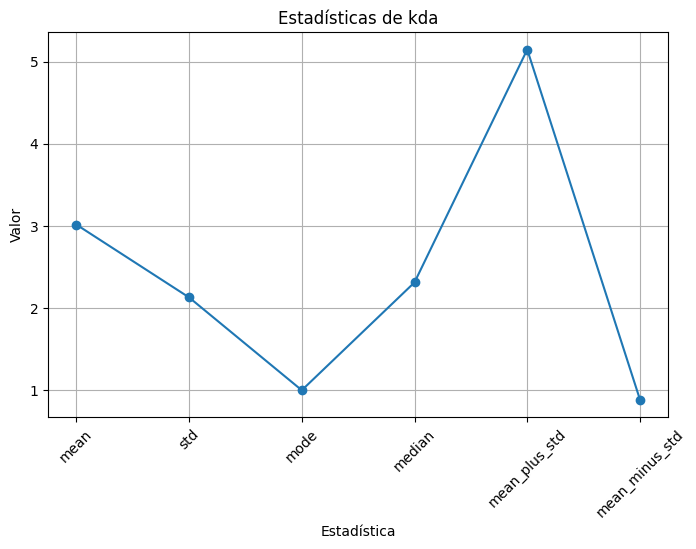

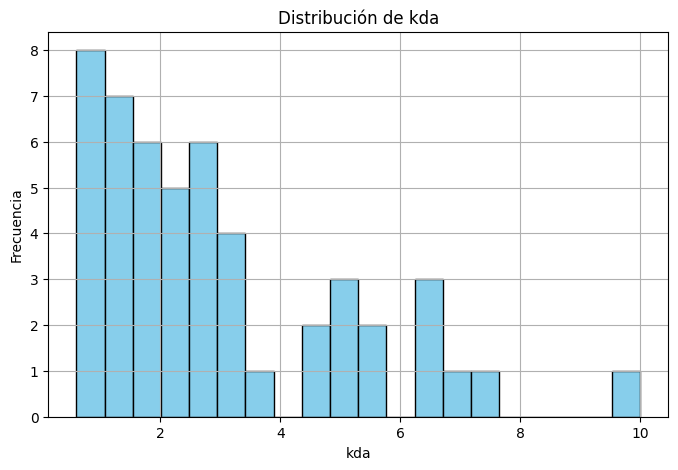

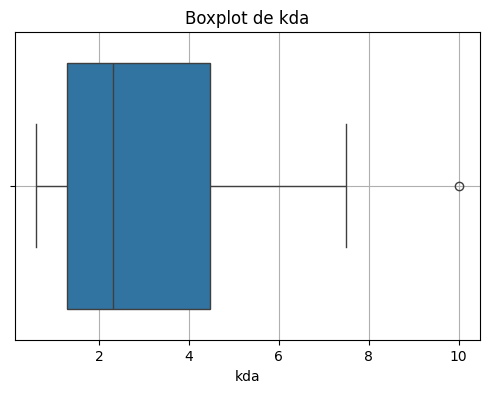


📊 Estadísticas para: dpm


,mean,std,mode,median,mean_plus_std,mean_minus_std
dpm,595.95,250.21,245.38,575.91,846.16,345.74


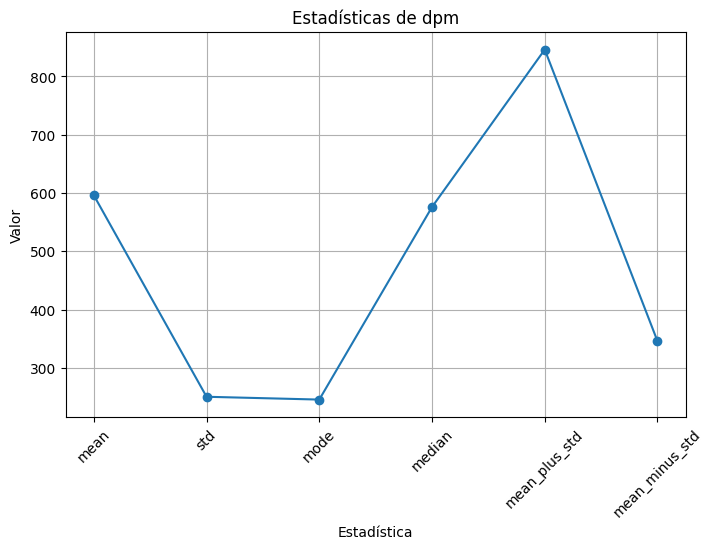

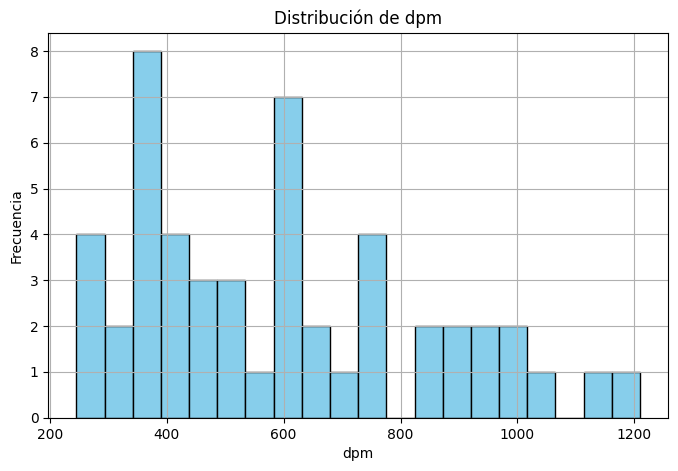

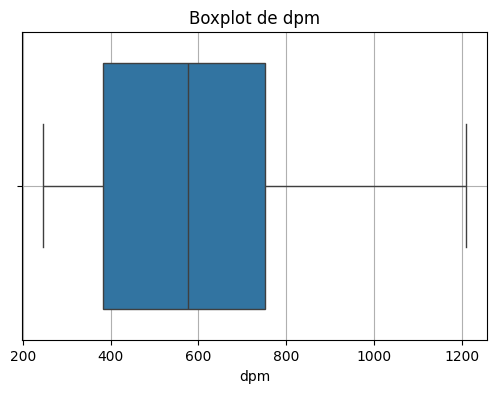


📊 Estadísticas para: cs_per_min


,mean,std,mode,median,mean_plus_std,mean_minus_std
cs_per_min,0.89,0.37,0.11,0.88,1.26,0.53


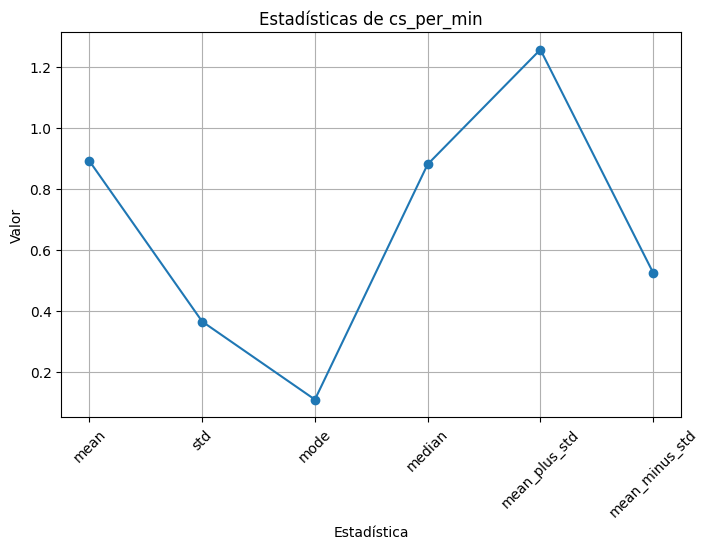

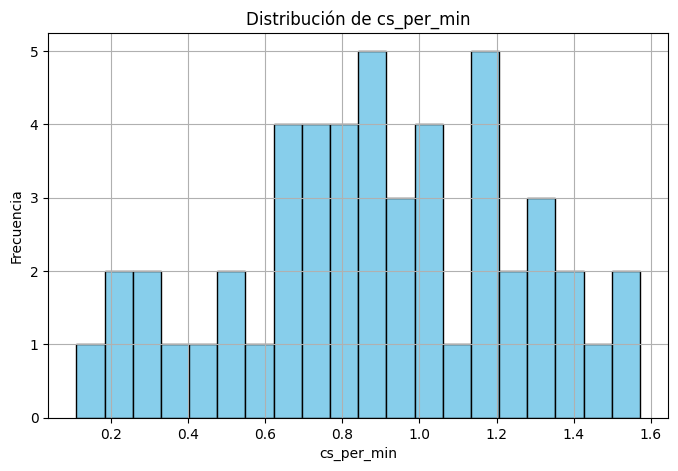

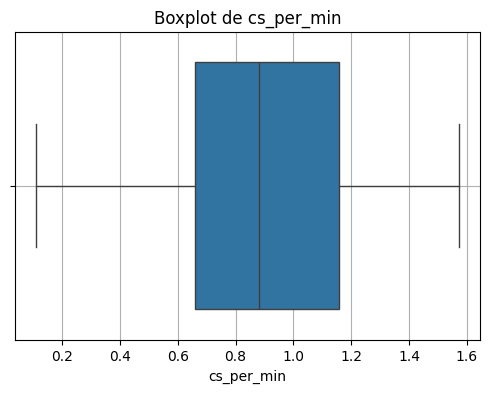


📊 Estadísticas para: kp


,mean,std,mode,median,mean_plus_std,mean_minus_std
kp,0.81,0.15,0.85,0.85,0.96,0.66


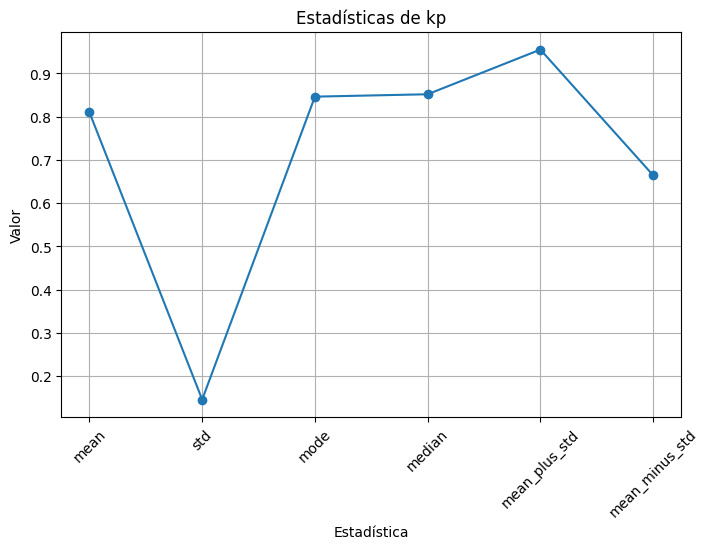

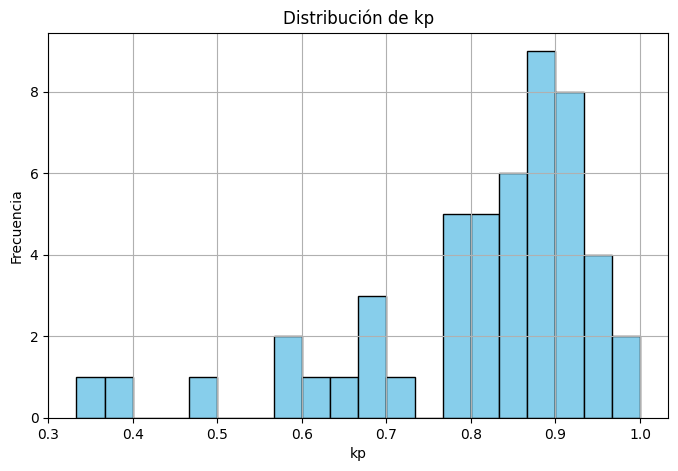

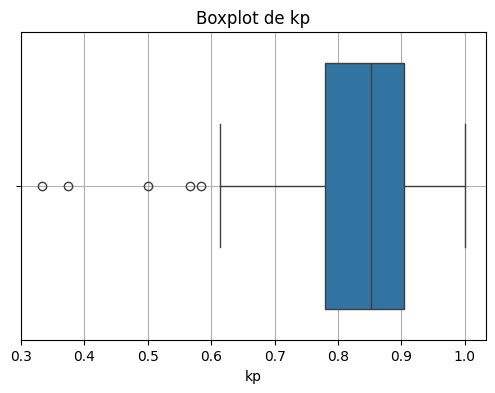

In [8]:
# Estadísticas extendidas
numeric_stats = numeric_df.describe().T
numeric_stats['std'] = numeric_df.std()
numeric_stats['mode'] = numeric_df.mode().iloc[0]
numeric_stats['median'] = numeric_df.median()
numeric_stats['mean_plus_std'] = numeric_stats['mean'] + numeric_stats['std']
numeric_stats['mean_minus_std'] = numeric_stats['mean'] - numeric_stats['std']
stats = ['mean', 'std', 'mode', 'median', 'mean_plus_std', 'mean_minus_std']

# Visualizaciones por columna con tabla de estadísticas
for column in numeric_df.columns:
    print(f"\n📊 Estadísticas para: {column}")
    display(numeric_stats.loc[[column], stats].style.format(precision=2))  # Mostrar tabla con formato bonito

    # Gráfica de líneas con las estadísticas
    plt.figure(figsize=(8, 5))
    plt.plot(stats, numeric_stats.loc[column, stats], marker='o', linestyle='-')
    plt.title(f'Estadísticas de {column}')
    plt.xlabel('Estadística')
    plt.ylabel('Valor')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Histograma
    plt.figure(figsize=(8, 5))
    plt.hist(numeric_df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    # Boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=numeric_df[column])
    plt.title(f'Boxplot de {column}')
    plt.grid(True)
    plt.show()

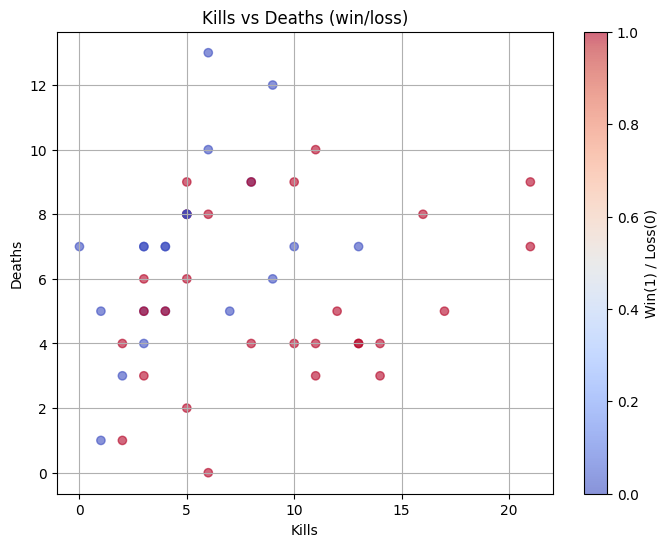

In [7]:
# Kills vs Deaths (Win color)
if {'kills', 'deaths', 'win'}.issubset(df.columns):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df['kills'], df['deaths'], alpha=0.6, c=df['win'].astype(int), cmap='coolwarm')
    plt.title('Kills vs Deaths (win/loss)')
    plt.xlabel('Kills')
    plt.ylabel('Deaths')
    plt.colorbar(scatter, label='Win(1) / Loss(0)')
    plt.grid(True)
    plt.show()